#Import librery

In [ ]:
!pip install keras-tuner -q
!pip install optuna -q

import os
import shutil
import warnings
import calendar
from os.path import isfile
from datetime import datetime, timedelta


try:
    from google.colab import drive
except ImportError:
    pass


import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import BeautifyIcon


%matplotlib inline
matplotlib.rc('figure', figsize=(15, 5))

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.random import set_seed as set_random_seed

import optuna
import keras_tuner as kt

warnings.filterwarnings("ignore")

output_folder = './Output_1'
os.makedirs(output_folder, exist_ok=True)


##Pre-procesamiento del dataset

In [ ]:
"""

# Lista
lista_df_transformados = []

# Columna id
#id_columns = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES']

# 1. Procesar todos los archivos
for i in 25:

    file_name = f'datos{i:02d}.csv'

    try:
        # Cargo el archivo
        df_temp = pd.read_csv(file_name, sep=';')

        # Transformo los datos
        df_melted = pd.wide_to_long(
            df_temp,
            stubnames=['D', 'V'],
            i=id_columns,
            j='DIA_NUMERO'
        ).reset_index()

        # Almacenao el resultado en la lista
        df_melted['FUENTE_ARCHIVO'] = file_name
        lista_df_transformados.append(df_melted)

        print(f"Archivo {file_name} procesado correctamente.")

    except FileNotFoundError:
        # Captura si algún archivo no existe y continúa con el siguiente
        print(f"Advertencia: El archivo {file_name} no fue encontrado")
    except Exception as e:
        # Captura cualquier otro error de lectura/transformación
        print(f"Error al procesar {file_name}: {e}")


# 4. Concatenar todos los DataFrames de la lista en uno solo
df_consolidado = pd.concat(lista_df_transformados, ignore_index=True)

# 5. Limpieza Final: Renombrar y Ordenar
df_consolidado = df_consolidado.rename(columns={'DIA_NUMERO': 'D'})
columnas_ordenadas = id_columns + ['D', 'V', 'FUENTE_ARCHIVO']
df_final = df_consolidado[columnas_ordenadas]


# 6. Mostrar el resultado final
print("Dataframe Consolidado")
print(df_final.head())
print(f"\nNúmero total de filas en el dataset final: {len(df_final):,}")

df_final.describe()
df_final.to_csv('df_2025.csv', sep=';', index=False)
"""


'\n\n# Lista\nlista_df_transformados = []\n\n# Columna id\n#id_columns = [\'PROVINCIA\', \'MUNICIPIO\', \'ESTACION\', \'MAGNITUD\', \'PUNTO_MUESTREO\', \'ANO\', \'MES\']\n\n# 1. Procesar todos los archivos\nfor i in 25:\n\n    file_name = f\'datos{i:02d}.csv\'\n\n    try:\n        # Cargo el archivo\n        df_temp = pd.read_csv(file_name, sep=\';\')\n\n        # Transformo los datos\n        df_melted = pd.wide_to_long(\n            df_temp,\n            stubnames=[\'D\', \'V\'],\n            i=id_columns,\n            j=\'DIA_NUMERO\'\n        ).reset_index()\n\n        # Almacenao el resultado en la lista\n        df_melted[\'FUENTE_ARCHIVO\'] = file_name\n        lista_df_transformados.append(df_melted)\n\n        print(f"Archivo {file_name} procesado correctamente.")\n\n    except FileNotFoundError:\n        # Captura si algún archivo no existe y continúa con el siguiente\n        print(f"Advertencia: El archivo {file_name} no fue encontrado")\n    except Exception as e:\n       

In [ ]:

"""
id_columns = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES']
file_2025 = 'datos25.csv'

try:

    df_temp = pd.read_csv(file_2025, sep=';')


    df_long = pd.wide_to_long(
        df_temp,
        stubnames=['D', 'V'],
        i=id_columns,
        j='DIA'
    ).reset_index()


    df_long['FUENTE_ARCHIVO'] = file_2025


    df_final_2025 = df_long.sort_values(by=['ANO', 'MES', 'DIA'])


    output_name = 'df_2025_procesado_2.csv'
    df_final_2025.to_csv(output_name, sep=';', index=False)

    print(f"Procesamiento completado: {output_name}")
    print(f"Dimensiones del dataset: {df_final_2025.shape}")
    print("\nResumen estadístico de la magnitud (CO2 u otros):")
    print(df_final_2025['D'].describe())
    print(df_final_2025['MES'].describe())

except FileNotFoundError:
    print(f"Error: El archivo {file_2025} no se encuentra en el directorio.")
except Exception as e:
    print(f"Error inesperado: {e}")"""

'\nid_columns = [\'PROVINCIA\', \'MUNICIPIO\', \'ESTACION\', \'MAGNITUD\', \'PUNTO_MUESTREO\', \'ANO\', \'MES\']\nfile_2025 = \'datos25.csv\'\n\ntry:\n\n    df_temp = pd.read_csv(file_2025, sep=\';\')\n\n\n    df_long = pd.wide_to_long(\n        df_temp,\n        stubnames=[\'D\', \'V\'],\n        i=id_columns,\n        j=\'DIA\'\n    ).reset_index()\n\n\n    df_long[\'FUENTE_ARCHIVO\'] = file_2025\n\n\n    df_final_2025 = df_long.sort_values(by=[\'ANO\', \'MES\', \'DIA\'])\n\n\n    output_name = \'df_2025_procesado_2.csv\'\n    df_final_2025.to_csv(output_name, sep=\';\', index=False)\n\n    print(f"Procesamiento completado: {output_name}")\n    print(f"Dimensiones del dataset: {df_final_2025.shape}")\n    print("\nResumen estadístico de la magnitud (CO2 u otros):")\n    print(df_final_2025[\'D\'].describe())\n    print(df_final_2025[\'MES\'].describe())\n\nexcept FileNotFoundError:\n    print(f"Error: El archivo {file_2025} no se encuentra en el directorio.")\nexcept Exception as e:\

##Anàlisis base estaciones

In [ ]:
"""
df_ubi = pd.read_excel('estacion.xls')

def arreglar_fecha_excel(numero):
    try:
        return datetime(1899, 12, 30) + timedelta(days=float(numero))
    except:
        return pd.NaT


if df_ubi['Fecha alta'].dtype != 'datetime64[ns]':
    df_ubi['Fecha_Real'] = df_ubi['Fecha alta'].apply(arreglar_fecha_excel)
else:
    df_ubi['Fecha_Real'] = df_ubi['Fecha alta']


df_ordenado = df_ubi.sort_values('Fecha_Real')

plt.figure(figsize=(10, 12))
plt.plot(df_ordenado['Fecha_Real'], df_ordenado['ESTACION'],
         marker='o',
         linestyle='-',
         linewidth=2,
         color='#1f77b4')
plt.title('Cronología de Alta de las Estaciones de Madrid', fontsize=16)
plt.xlabel('Fecha de Alta', fontsize=12)
plt.ylabel('Estación', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()"""

"\ndf_ubi = pd.read_excel('estacion.xls')\n\ndef arreglar_fecha_excel(numero):\n    try:\n        return datetime(1899, 12, 30) + timedelta(days=float(numero))\n    except:\n        return pd.NaT\n\n\nif df_ubi['Fecha alta'].dtype != 'datetime64[ns]':\n    df_ubi['Fecha_Real'] = df_ubi['Fecha alta'].apply(arreglar_fecha_excel)\nelse:\n    df_ubi['Fecha_Real'] = df_ubi['Fecha alta']\n\n\ndf_ordenado = df_ubi.sort_values('Fecha_Real')\n\nplt.figure(figsize=(10, 12))\nplt.plot(df_ordenado['Fecha_Real'], df_ordenado['ESTACION'],\n         marker='o',\n         linestyle='-',\n         linewidth=2,\n         color='#1f77b4')\nplt.title('Cronología de Alta de las Estaciones de Madrid', fontsize=16)\nplt.xlabel('Fecha de Alta', fontsize=12)\nplt.ylabel('Estación', fontsize=12)\nplt.grid(True, linestyle='--', alpha=0.5)\nplt.tight_layout()\nplt.show()"

In [ ]:
"""
mapa_madrid = folium.Map(location=[40.4168, -3.7038], zoom_start=12)

for index, fila in df_ubi.iterrows():

    lat = fila['LATITUD']
    lon = fila['LONGITUD']
    nombre = fila['ESTACION']

    numero = int(fila['CODIGO_CORTO'])


    folium.Marker(
        location=[lat, lon],
        popup=nombre,
        tooltip=nombre,


        icon=BeautifyIcon(
            icon_shape='marker',      # Forma de "pin" (o puedes poner 'circle')
            number=numero,            # Aquí va el número que leímos
            border_color='#0078A8',   # Color del borde (azul bonito)
            text_color='#0078A8',     # Color del número
            background_color='white'  # Fondo blanco para que se lea bien
        )
    ).add_to(mapa_madrid)

nombre_archivo = 'Mapa_Estaciones_Numerado.html'
mapa_madrid.save(nombre_archivo)

print(f"'{nombre_archivo}'")"""

'\nmapa_madrid = folium.Map(location=[40.4168, -3.7038], zoom_start=12)\n\nfor index, fila in df_ubi.iterrows():\n\n    lat = fila[\'LATITUD\']\n    lon = fila[\'LONGITUD\']\n    nombre = fila[\'ESTACION\']\n\n    numero = int(fila[\'CODIGO_CORTO\'])\n\n\n    folium.Marker(\n        location=[lat, lon],\n        popup=nombre,\n        tooltip=nombre,\n\n\n        icon=BeautifyIcon(\n            icon_shape=\'marker\',      # Forma de "pin" (o puedes poner \'circle\')\n            number=numero,            # Aquí va el número que leímos\n            border_color=\'#0078A8\',   # Color del borde (azul bonito)\n            text_color=\'#0078A8\',     # Color del número\n            background_color=\'white\'  # Fondo blanco para que se lea bien\n        )\n    ).add_to(mapa_madrid)\n\nnombre_archivo = \'Mapa_Estaciones_Numerado.html\'\nmapa_madrid.save(nombre_archivo)\n\nprint(f"\'{nombre_archivo}\'")'

#Read dataset


##Lectura de drive

In [ ]:
#Dataset
# Conexion drive
drive_path = '/content/drive'
drive.mount(drive_path)

# Ruta de drive
FILE_NAME = 'df_ok.csv'
DRIVE_FOLDER = 'Facultades/UAM/TFM'
FILE_PATH = os.path.join(drive_path, 'MyDrive', DRIVE_FOLDER, FILE_NAME)

# Lectura dataset
df = pd.read_csv(FILE_PATH, sep=';' )
print(f"Ruta: {FILE_PATH}")
print(f"Dimesión: {df.shape}")

# Check
print(df.head())


Mounted at /content/drive
Ruta: /content/drive/MyDrive/Facultades/UAM/TFM/df_ok.csv
Dimesión: (1081795, 11)
   PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO   ANO  MES  D  \
0         28         79         4         1  28079004_1_38  2001    1  1   
1         28         79         4         1  28079004_1_38  2001    1  2   
2         28         79         4         1  28079004_1_38  2001    1  3   
3         28         79         4         1  28079004_1_38  2001    1  4   
4         28         79         4         1  28079004_1_38  2001    1  5   

    D.1  V FUENTE_ARCHIVO  
0  17.0  V    datos01.csv  
1  15.0  V    datos01.csv  
2  15.0  V    datos01.csv  
3  15.0  V    datos01.csv  
4  16.0  V    datos01.csv  


In [ ]:
# Dataset test
# Conexion drive
drive_path = '/content/drive'
drive.mount(drive_path)

# Ruta de drive
FILE_NAME = 'df_2025_procesado.csv'
DRIVE_FOLDER = 'Facultades/UAM/TFM'
FILE_PATH = os.path.join(drive_path, 'MyDrive', DRIVE_FOLDER, FILE_NAME)

# Lectura dataset
df_2025 = pd.read_csv(FILE_PATH, sep=';' )
print(f"Ruta: {FILE_PATH}")
print(f"Dimesión: {df.shape}")

# Check
print(df_2025.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ruta: /content/drive/MyDrive/Facultades/UAM/TFM/df_2025_procesado.csv
Dimesión: (1081795, 11)
   PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO   ANO  MES  DIA  \
0         28         79        11        12   28079011_12_8  2025    1    1   
1         28         79        11        20  28079011_20_59  2025    1    1   
2         28         79        11        30  28079011_30_59  2025    1    1   
3         28         79        11        35  28079011_35_59  2025    1    1   
4         28         79        11         7    28079011_7_8  2025    1    1   

      D  V FUENTE_ARCHIVO  
0  68.0  V    datos25.csv  
1   1.5  V    datos25.csv  
2   0.5  V    datos25.csv  
3   0.2  V    datos25.csv  
4  18.0  V    datos25.csv  


In [ ]:
df_2025.head()

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO   ANO  MES  DIA  \
0         28         79        11        12   28079011_12_8  2025    1    1   
1         28         79        11        20  28079011_20_59  2025    1    1   
2         28         79        11        30  28079011_30_59  2025    1    1   
3         28         79        11        35  28079011_35_59  2025    1    1   
4         28         79        11         7    28079011_7_8  2025    1    1   

      D  V FUENTE_ARCHIVO  
0  68.0  V    datos25.csv  
1   1.5  V    datos25.csv  
2   0.5  V    datos25.csv  
3   0.2  V    datos25.csv  
4  18.0  V    datos25.csv

## Campos nuevos

In [ ]:
df = df.rename(columns={'ANO': 'year', 'MES': 'month', 'D': 'day'})
df_2025 = df_2025.rename(columns={'ANO': 'year', 'MES': 'month', 'DIA': 'day','D': 'D.1'})


In [ ]:
df[['year', 'month', 'day']] = df[['year', 'month', 'day']].astype(int)

df['date'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')

df = df.sort_values('date')

In [ ]:
df

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  \
0               28         79         4         1   28079004_1_38  2001   
19778           28         79        38         1   28079038_1_38  2001   
2511            28         79         8         8    28079008_8_8  2001   
19406           28         79        36        12   28079036_12_8  2001   
2728            28         79         8        10  28079008_10_47  2001   
...            ...        ...       ...       ...             ...   ...   
1077559         28         79        60        14   28079060_14_6  2024   
1077621         28         79        60        14   28079060_14_6  2024   
1077683         28         79        60        14   28079060_14_6  2024   
1077776         28         79        60        14   28079060_14_6  2024   
1077838         28         79        60        14   28079060_14_6  2024   

         month  day   D.1  V FUENTE_ARCHIVO       date  
0            1    1  17.0  V    datos01.csv 2001-01-01  
19778        1    1  32.0  V    datos01.csv 2001-01-01  
2511         1    1  53.0  V    datos01.csv 2001-01-01  
19406        1    1  81.0  V    datos01.csv 2001-01-01  
2728         1    1  20.0  V    datos01.csv 2001-01-01  
...        ...  ...   ... ..            ...        ...  
1077559      2   31   0.0  N    datos24.csv        NaT  
1077621      4   31   0.0  N    datos24.csv        NaT  
1077683      6   31   0.0  N    datos24.csv        NaT  
1077776      9   31   0.0  N    datos24.csv        NaT  
1077838     11   31   0.0  N    datos24.csv        NaT  

[1081795 rows x 12 columns]

In [ ]:
df_invalidas = df[df['date'].isna()]
df_invalidas

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO  year  month  \
59              28         79         4         1  28079004_1_38  2001      2   
60              28         79         4         1  28079004_1_38  2001      2   
61              28         79         4         1  28079004_1_38  2001      2   
123             28         79         4         1  28079004_1_38  2001      4   
185             28         79         4         1  28079004_1_38  2001      6   
...            ...        ...       ...       ...            ...   ...    ...   
1077559         28         79        60        14  28079060_14_6  2024      2   
1077621         28         79        60        14  28079060_14_6  2024      4   
1077683         28         79        60        14  28079060_14_6  2024      6   
1077776         28         79        60        14  28079060_14_6  2024      9   
1077838         28         79        60        14  28079060_14_6  2024     11   

         day  D.1  V FUENTE_ARCHIVO date  
59        29  0.0  N    datos01.csv  NaT  
60        30  0.0  N    datos01.csv  NaT  
61        31  0.0  N    datos01.csv  NaT  
123       31  0.0  N    datos01.csv  NaT  
185       31  0.0  N    datos01.csv  NaT  
...      ...  ... ..            ...  ...  
1077559   31  0.0  N    datos24.csv  NaT  
1077621   31  0.0  N    datos24.csv  NaT  
1077683   31  0.0  N    datos24.csv  NaT  
1077776   31  0.0  N    datos24.csv  NaT  
1077838   31  0.0  N    datos24.csv  NaT  

[19555 rows x 12 columns]

In [ ]:
df_2025[['year', 'month', 'day']] = df_2025[['year', 'month', 'day']].astype(int)

df_2025['date'] = pd.to_datetime(df_2025[['year', 'month', 'day']], errors='coerce')

In [ ]:
df_2025

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  month  \
0             28         79        11        12   28079011_12_8  2025      1   
1             28         79        11        20  28079011_20_59  2025      1   
2             28         79        11        30  28079011_30_59  2025      1   
3             28         79        11        35  28079011_35_59  2025      1   
4             28         79        11         7    28079011_7_8  2025      1   
...          ...        ...       ...       ...             ...   ...    ...   
48665         28         79         8        35  28079008_35_59  2025     12   
48666         28         79         8         6   28079008_6_48  2025     12   
48667         28         79         8         7    28079008_7_8  2025     12   
48668         28         79         8         8    28079008_8_8  2025     12   
48669         28         79         8         9   28079008_9_47  2025     12   

       day   D.1  V FUENTE_ARCHIVO       date  
0        1  68.0  V    datos25.csv 2025-01-01  
1        1   1.5  V    datos25.csv 2025-01-01  
2        1   0.5  V    datos25.csv 2025-01-01  
3        1   0.2  V    datos25.csv 2025-01-01  
4        1  18.0  V    datos25.csv 2025-01-01  
...    ...   ... ..            ...        ...  
48665   31   0.6  V    datos25.csv 2025-12-31  
48666   31   0.6  V    datos25.csv 2025-12-31  
48667   31  24.0  V    datos25.csv 2025-12-31  
48668   31  44.0  V    datos25.csv 2025-12-31  
48669   31  13.0  V    datos25.csv 2025-12-31  

[48670 rows x 12 columns]

Datos invalidos

In [ ]:
df_invalidas = df_2025[df_2025['date'].isna()]
df_invalidas

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  month  \
7906          28         79        11        12   28079011_12_8  2025      2   
7907          28         79        11        20  28079011_20_59  2025      2   
7908          28         79        11        30  28079011_30_59  2025      2   
7909          28         79        11        35  28079011_35_59  2025      2   
7910          28         79        11         7    28079011_7_8  2025      2   
...          ...        ...       ...       ...             ...   ...    ...   
44759         28         79         8        35  28079008_35_59  2025     11   
44760         28         79         8         6   28079008_6_48  2025     11   
44761         28         79         8         7    28079008_7_8  2025     11   
44762         28         79         8         8    28079008_8_8  2025     11   
44763         28         79         8         9   28079008_9_47  2025     11   

       day  D.1  V FUENTE_ARCHIVO date  
7906    29  0.0  N    datos25.csv  NaT  
7907    29  0.0  N    datos25.csv  NaT  
7908    29  0.0  N    datos25.csv  NaT  
7909    29  0.0  N    datos25.csv  NaT  
7910    29  0.0  N    datos25.csv  NaT  
...    ...  ... ..            ...  ...  
44759   31  0.0  N    datos25.csv  NaT  
44760   31  0.0  N    datos25.csv  NaT  
44761   31  0.0  N    datos25.csv  NaT  
44762   31  0.0  N    datos25.csv  NaT  
44763   31  0.0  N    datos25.csv  NaT  

[920 rows x 12 columns]

In [ ]:
df = df.dropna(subset=['date'])

In [ ]:
df.head()

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  month  \
0             28         79         4         1   28079004_1_38  2001      1   
19778         28         79        38         1   28079038_1_38  2001      1   
2511          28         79         8         8    28079008_8_8  2001      1   
19406         28         79        36        12   28079036_12_8  2001      1   
2728          28         79         8        10  28079008_10_47  2001      1   

       day   D.1  V FUENTE_ARCHIVO       date  
0        1  17.0  V    datos01.csv 2001-01-01  
19778    1  32.0  V    datos01.csv 2001-01-01  
2511     1  53.0  V    datos01.csv 2001-01-01  
19406    1  81.0  V    datos01.csv 2001-01-01  
2728     1  20.0  V    datos01.csv 2001-01-01

In [ ]:
df_2025 = df_2025.dropna(subset=['date'])

In [ ]:
df_2025

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  month  \
0             28         79        11        12   28079011_12_8  2025      1   
1             28         79        11        20  28079011_20_59  2025      1   
2             28         79        11        30  28079011_30_59  2025      1   
3             28         79        11        35  28079011_35_59  2025      1   
4             28         79        11         7    28079011_7_8  2025      1   
...          ...        ...       ...       ...             ...   ...    ...   
48665         28         79         8        35  28079008_35_59  2025     12   
48666         28         79         8         6   28079008_6_48  2025     12   
48667         28         79         8         7    28079008_7_8  2025     12   
48668         28         79         8         8    28079008_8_8  2025     12   
48669         28         79         8         9   28079008_9_47  2025     12   

       day   D.1  V FUENTE_ARCHIVO       date  
0        1  68.0  V    datos25.csv 2025-01-01  
1        1   1.5  V    datos25.csv 2025-01-01  
2        1   0.5  V    datos25.csv 2025-01-01  
3        1   0.2  V    datos25.csv 2025-01-01  
4        1  18.0  V    datos25.csv 2025-01-01  
...    ...   ... ..            ...        ...  
48665   31   0.6  V    datos25.csv 2025-12-31  
48666   31   0.6  V    datos25.csv 2025-12-31  
48667   31  24.0  V    datos25.csv 2025-12-31  
48668   31  44.0  V    datos25.csv 2025-12-31  
48669   31  13.0  V    datos25.csv 2025-12-31  

[47750 rows x 12 columns]

In [ ]:
df['year'].value_counts().sort_index()


year
2001    24868
2002    24335
2003    30908
2004    30773
2005    30692
2006    29135
2007    29270
2008    29646
2009    31930
2010    54995
2011    56210
2012    55815
2013    55115
2014    54902
2015    55115
2016    55266
2017    55115
2018    54932
2019    55845
2020    55998
2021    49163
2022    47637
2023    47646
2024    46929
Name: count, dtype: int64

Validacion de días por años

In [ ]:
df_validacion = (
    df.groupby('year')['day']
      .count()
      .reset_index(name='dias_registrados')
)

df_validacion['dias_en_calendario'] = df_validacion['year'].apply(
    lambda año: 366 if calendar.isleap(año) else 365
)

df_validacion['completo'] = df_validacion['dias_registrados'] == df_validacion['dias_en_calendario']

print(df_validacion)

    year  dias_registrados  dias_en_calendario  completo
0   2001             24868                 365     False
1   2002             24335                 365     False
2   2003             30908                 365     False
3   2004             30773                 366     False
4   2005             30692                 365     False
5   2006             29135                 365     False
6   2007             29270                 365     False
7   2008             29646                 366     False
8   2009             31930                 365     False
9   2010             54995                 365     False
10  2011             56210                 365     False
11  2012             55815                 366     False
12  2013             55115                 365     False
13  2014             54902                 365     False
14  2015             55115                 365     False
15  2016             55266                 366     False
16  2017             55115     

In [ ]:
df_validacion_2025 = (
    df_2025.groupby('year')['day']
      .count()
      .reset_index(name='dias_registrados')
)

df_validacion_2025['dias_en_calendario'] = df_validacion_2025['year'].apply(
    lambda año: 366 if calendar.isleap(año) else 365
)

df_validacion_2025['completo'] = df_validacion_2025['dias_registrados'] == df_validacion_2025['dias_en_calendario']

print(df_validacion_2025)

   year  dias_registrados  dias_en_calendario  completo
0  2025             47750                 365     False


#Analtica


##Valores Nulos

In [ ]:
#Conteo de valores nulos

print("Valores nulos:")


null_counts = df.isna().sum()

print(null_counts)


Valores nulos:
PROVINCIA         0
MUNICIPIO         0
ESTACION          0
MAGNITUD          0
PUNTO_MUESTREO    0
year              0
month             0
day               0
D.1               0
V                 0
FUENTE_ARCHIVO    0
date              0
dtype: int64


In [ ]:
null_counts_2025 = df_2025.isna().sum()

print(null_counts_2025)

PROVINCIA         0
MUNICIPIO         0
ESTACION          0
MAGNITUD          0
PUNTO_MUESTREO    0
year              0
month             0
day               0
D.1               0
V                 0
FUENTE_ARCHIVO    0
date              0
dtype: int64


##Outliers


In [ ]:
df.groupby('year')['D.1'].mean()

year
2001    49.206896
2002    43.778675
2003    39.511956
2004    41.699214
2005    40.701033
2006    36.488950
2007    34.812812
2008    31.665876
2009    31.185399
2010    29.592962
2011    32.019857
2012    28.653758
2013    29.714275
2014    26.605554
2015    31.619906
2016    28.630440
2017    29.767475
2018    26.083481
2019    24.505935
2020    20.394370
2021    22.638303
2022    22.750702
2023    23.025830
2024    21.466255
Name: D.1, dtype: float64

In [ ]:
df.groupby('year')['D.1'].quantile(0.99)

year
2001    381.33
2002    296.66
2003    269.00
2004    312.28
2005    302.00
2006    261.00
2007    253.00
2008    211.00
2009    205.00
2010    182.06
2011    232.00
2012    203.00
2013    179.00
2014    176.00
2015    241.00
2016    186.00
2017    211.00
2018    166.00
2019    163.00
2020    128.00
2021    121.00
2022    113.00
2023    122.00
2024    111.00
Name: D.1, dtype: float64

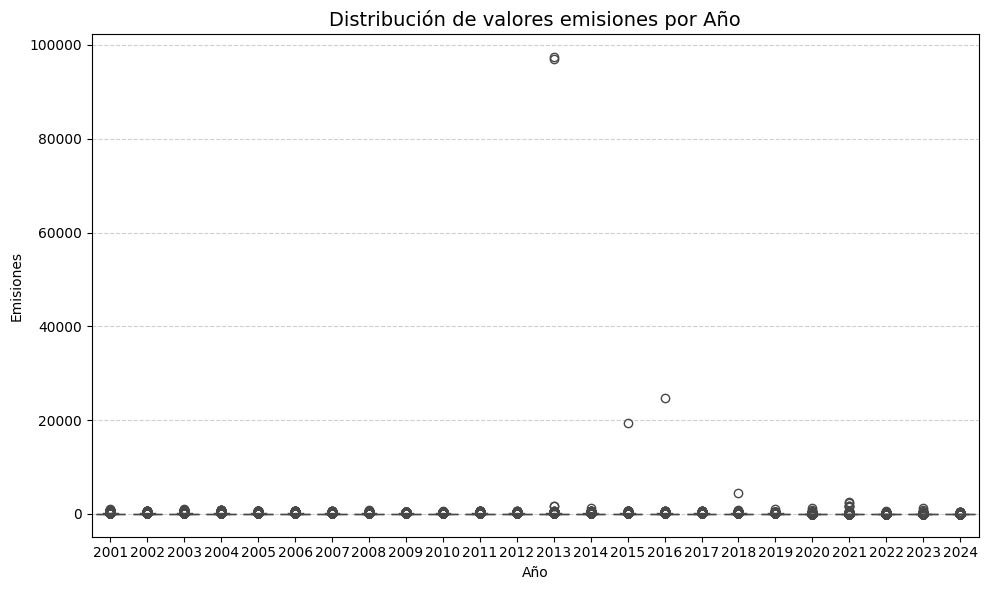

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='year', y='D.1', palette='coolwarm')
plt.title('Distribución de valores emisiones por Año', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Emisiones')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

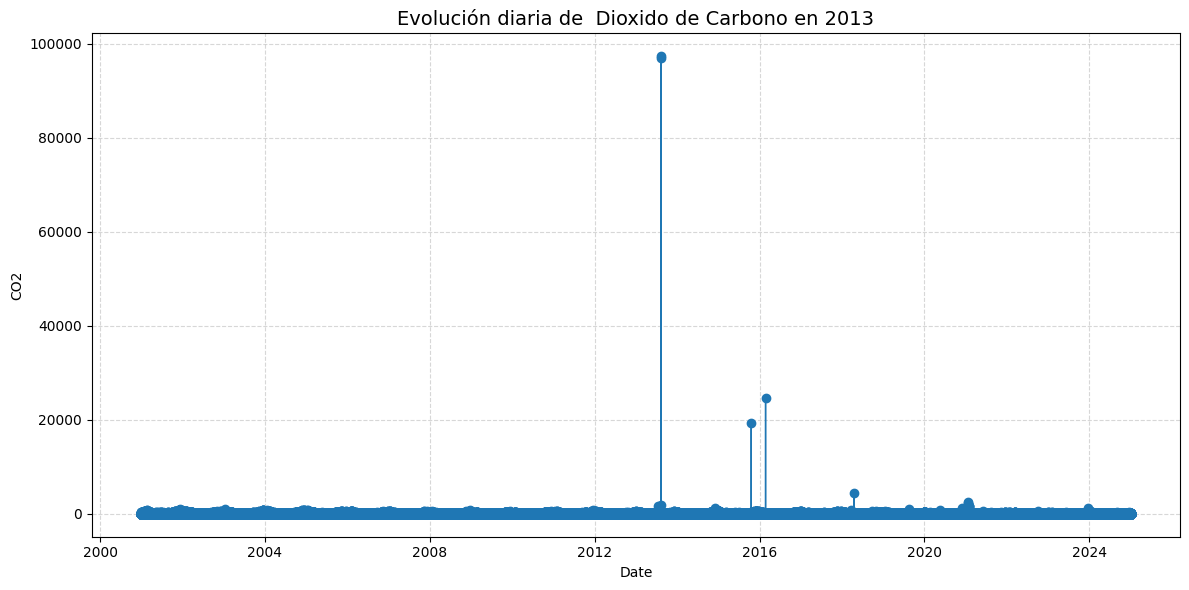

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['D.1'], marker='o', linewidth=1)

plt.title('Evolución diaria de  Dioxido de Carbono en 2013', fontsize=14)
plt.xlabel('Date')
plt.ylabel('CO2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#Filtramos desde el 2010
df= df[df['year'] > 2009]

#Check emisiones >500
df_500 = df[df['D.1'] > 500]

print(len(df_500))
print(df_500[['date', 'D.1']].sort_values(by='date', ascending=False))


100
              date     D.1
1002838 2023-12-20   906.8
1002837 2023-12-19  1235.6
959417  2022-09-30   574.0
936048  2021-06-04   677.0
887556  2021-01-27  1583.0
...            ...     ...
355945  2011-02-04   562.0
334741  2011-02-04   537.0
355944  2011-02-03   514.0
334720  2011-01-14   544.0
274548  2010-12-13   507.0

[100 rows x 2 columns]


In [ ]:
df

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  \
299553          28         79        39        12   28079039_12_8  2010   
298809          28         79        39         7    28079039_7_8  2010   
309411          28         79        54        14   28079054_14_6  2010   
283557          28         79        24         7    28079024_7_8  2010   
315735          28         79        57         6   28079057_6_48  2010   
...            ...        ...       ...       ...             ...   ...   
1079562         28         79        36         8    28079036_8_8  2024   
1079531         28         79        36         7    28079036_7_8  2024   
1079500         28         79        36         1   28079036_1_38  2024   
1079748         28         79        38        10  28079038_10_47  2024   
1081794         28         79        60        14   28079060_14_6  2024   

         month  day    D.1  V FUENTE_ARCHIVO       date  
299553       1    1  38.00  V    datos10.csv 2010-01-01  
298809       1    1   9.00  V    datos10.csv 2010-01-01  
309411       1    1  71.00  V    datos10.csv 2010-01-01  
283557       1    1   2.00  V    datos10.csv 2010-01-01  
315735       1    1   0.20  V    datos10.csv 2010-01-01  
...        ...  ...    ... ..            ...        ...  
1079562     12   31  41.96  V    datos24.csv 2024-12-31  
1079531     12   31  14.33  V    datos24.csv 2024-12-31  
1079500     12   31   2.63  V    datos24.csv 2024-12-31  
1079748     12   31  15.08  V    datos24.csv 2024-12-31  
1081794     12   31  35.13  V    datos24.csv 2024-12-31  

[800683 rows x 12 columns]

In [ ]:
df.value_counts('ESTACION')

ESTACION
8     70595
24    68356
18    52233
55    50134
38    47881
11    32706
35    32508
57    31809
36    31444
56    30318
60    27395
47    27395
50    27240
48    26640
27    26629
4     26429
39    25965
40    25965
16    25717
17    25660
49    21916
54    21916
58    21916
59    21916
Name: count, dtype: int64

In [ ]:
df_2025.head()

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  month  day  \
0         28         79        11        12   28079011_12_8  2025      1    1   
1         28         79        11        20  28079011_20_59  2025      1    1   
2         28         79        11        30  28079011_30_59  2025      1    1   
3         28         79        11        35  28079011_35_59  2025      1    1   
4         28         79        11         7    28079011_7_8  2025      1    1   

    D.1  V FUENTE_ARCHIVO       date  
0  68.0  V    datos25.csv 2025-01-01  
1   1.5  V    datos25.csv 2025-01-01  
2   0.5  V    datos25.csv 2025-01-01  
3   0.2  V    datos25.csv 2025-01-01  
4  18.0  V    datos25.csv 2025-01-01

In [ ]:
df.head()

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO  year  month  \
299553         28         79        39        12  28079039_12_8  2010      1   
298809         28         79        39         7   28079039_7_8  2010      1   
309411         28         79        54        14  28079054_14_6  2010      1   
283557         28         79        24         7   28079024_7_8  2010      1   
315735         28         79        57         6  28079057_6_48  2010      1   

        day   D.1  V FUENTE_ARCHIVO       date  
299553    1  38.0  V    datos10.csv 2010-01-01  
298809    1   9.0  V    datos10.csv 2010-01-01  
309411    1  71.0  V    datos10.csv 2010-01-01  
283557    1   2.0  V    datos10.csv 2010-01-01  
315735    1   0.2  V    datos10.csv 2010-01-01

In [ ]:
##df = df[df["MAGNITUF"] == 6]


In [ ]:
df

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  \
299553          28         79        39        12   28079039_12_8  2010   
298809          28         79        39         7    28079039_7_8  2010   
309411          28         79        54        14   28079054_14_6  2010   
283557          28         79        24         7    28079024_7_8  2010   
315735          28         79        57         6   28079057_6_48  2010   
...            ...        ...       ...       ...             ...   ...   
1079562         28         79        36         8    28079036_8_8  2024   
1079531         28         79        36         7    28079036_7_8  2024   
1079500         28         79        36         1   28079036_1_38  2024   
1079748         28         79        38        10  28079038_10_47  2024   
1081794         28         79        60        14   28079060_14_6  2024   

         month  day    D.1  V FUENTE_ARCHIVO       date  
299553       1    1  38.00  V    datos10.csv 2010-01-01  
298809       1    1   9.00  V    datos10.csv 2010-01-01  
309411       1    1  71.00  V    datos10.csv 2010-01-01  
283557       1    1   2.00  V    datos10.csv 2010-01-01  
315735       1    1   0.20  V    datos10.csv 2010-01-01  
...        ...  ...    ... ..            ...        ...  
1079562     12   31  41.96  V    datos24.csv 2024-12-31  
1079531     12   31  14.33  V    datos24.csv 2024-12-31  
1079500     12   31   2.63  V    datos24.csv 2024-12-31  
1079748     12   31  15.08  V    datos24.csv 2024-12-31  
1081794     12   31  35.13  V    datos24.csv 2024-12-31  

[800683 rows x 12 columns]

##KNN

In [ ]:
#Elimino los valores mayores a 500 y los valores 0

df.loc[(df['D.1'] > 500) , 'D.1'] = np.nan

#Segemento la informacion por estacion tambien para mejorar los imputer
df_aux = df.copy()
df_aux['estacion_cat'] = df_aux['ESTACION'].astype('category').cat.codes


columnas_para_imputar = ['D.1', 'estacion_cat']

imputer = KNNImputer(n_neighbors=10)
imputed_data = imputer.fit_transform(df_aux[columnas_para_imputar])

#Valores imputados
df['D.1'] = imputed_data[:, 0]

# Verificacion
print(f"Valores nulos después de imputar: {df['D.1'].isnull().sum()}")

Valores nulos después de imputar: 0


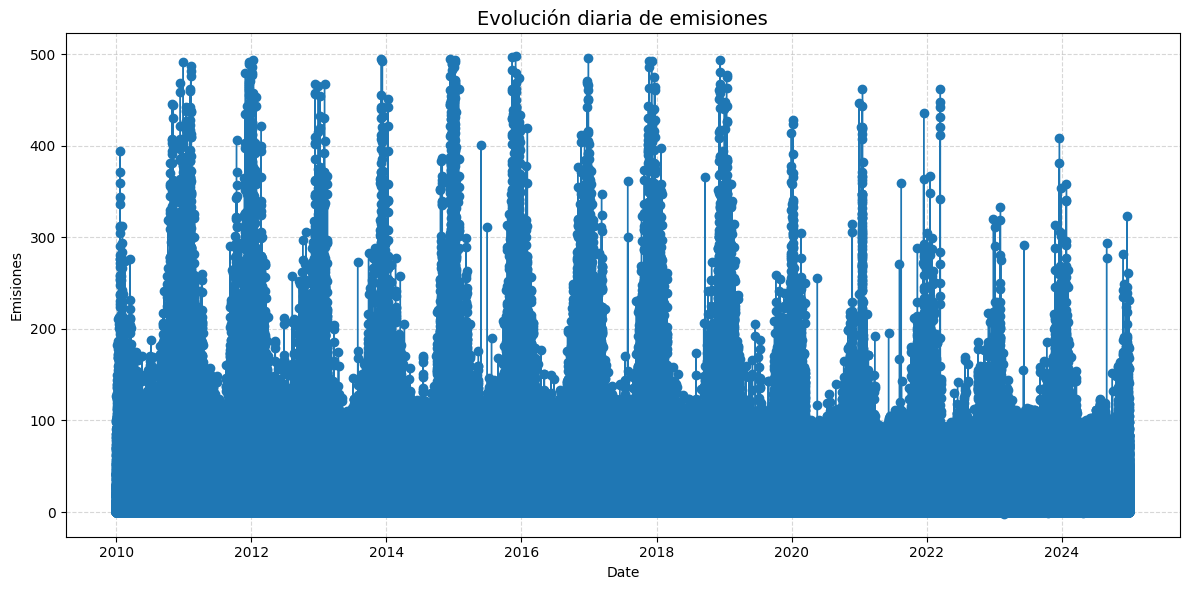

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['D.1'], marker='o', linewidth=1)

plt.title('Evolución diaria de emisiones', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Emisiones')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
df.head()

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO  year  month  \
299553         28         79        39        12  28079039_12_8  2010      1   
298809         28         79        39         7   28079039_7_8  2010      1   
309411         28         79        54        14  28079054_14_6  2010      1   
283557         28         79        24         7   28079024_7_8  2010      1   
315735         28         79        57         6  28079057_6_48  2010      1   

        day   D.1  V FUENTE_ARCHIVO       date  
299553    1  38.0  V    datos10.csv 2010-01-01  
298809    1   9.0  V    datos10.csv 2010-01-01  
309411    1  71.0  V    datos10.csv 2010-01-01  
283557    1   2.0  V    datos10.csv 2010-01-01  
315735    1   0.2  V    datos10.csv 2010-01-01

In [ ]:
df_2025.head()

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  month  day  \
0         28         79        11        12   28079011_12_8  2025      1    1   
1         28         79        11        20  28079011_20_59  2025      1    1   
2         28         79        11        30  28079011_30_59  2025      1    1   
3         28         79        11        35  28079011_35_59  2025      1    1   
4         28         79        11         7    28079011_7_8  2025      1    1   

    D.1  V FUENTE_ARCHIVO       date  
0  68.0  V    datos25.csv 2025-01-01  
1   1.5  V    datos25.csv 2025-01-01  
2   0.5  V    datos25.csv 2025-01-01  
3   0.2  V    datos25.csv 2025-01-01  
4  18.0  V    datos25.csv 2025-01-01

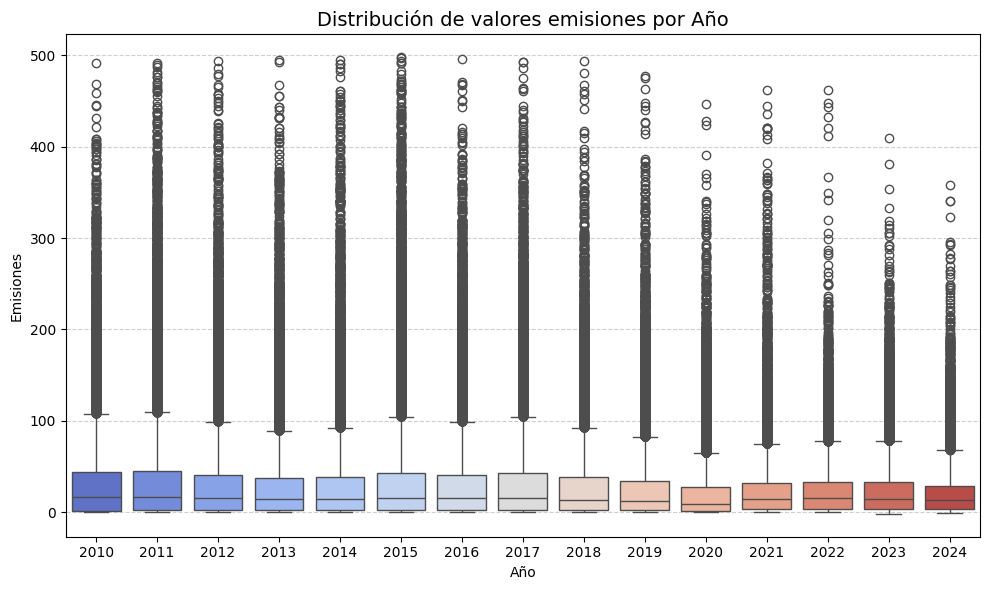

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='year', y='D.1', palette='coolwarm')
plt.title('Distribución de valores emisiones por Año', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Emisiones')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

##Analisis

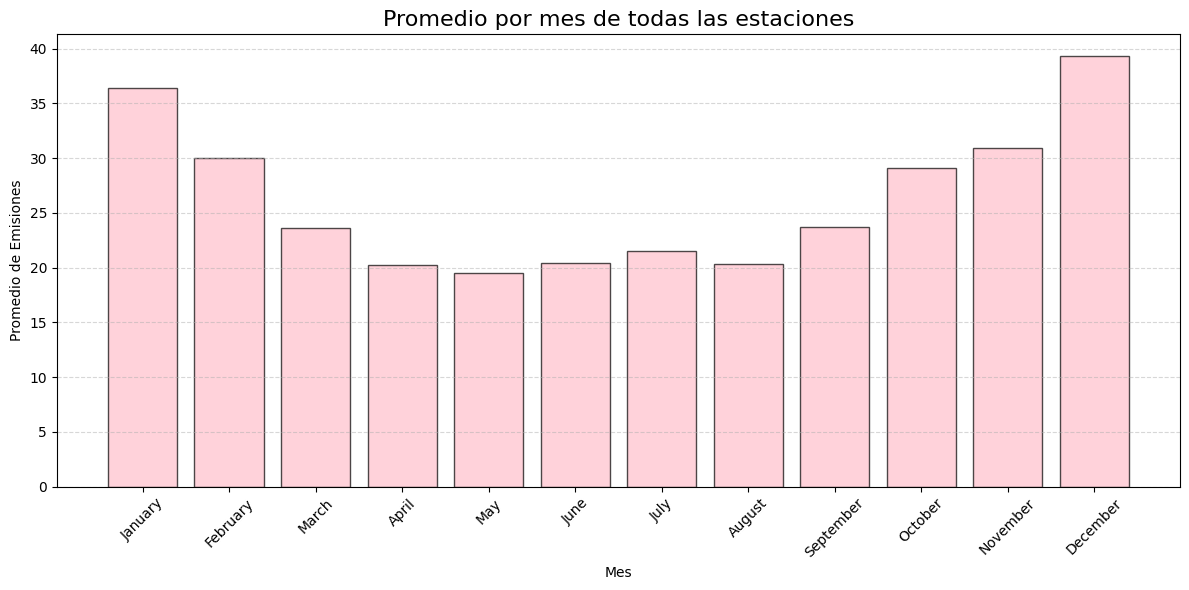

In [ ]:
promedio_mensual = df.groupby(df['date'].dt.month)['D.1'].mean()

plt.figure(figsize=(12, 6))

plt.bar(promedio_mensual.index, promedio_mensual.values, color='pink', edgecolor='black', alpha=0.7)

nombres_meses = [calendar.month_name[i] for i in range(1, 13)]
plt.xticks(promedio_mensual.index, nombres_meses, rotation=45)

plt.title('Promedio por mes de todas las estaciones', fontsize=16)
plt.xlabel('Mes')
plt.ylabel('Promedio de Emisiones')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

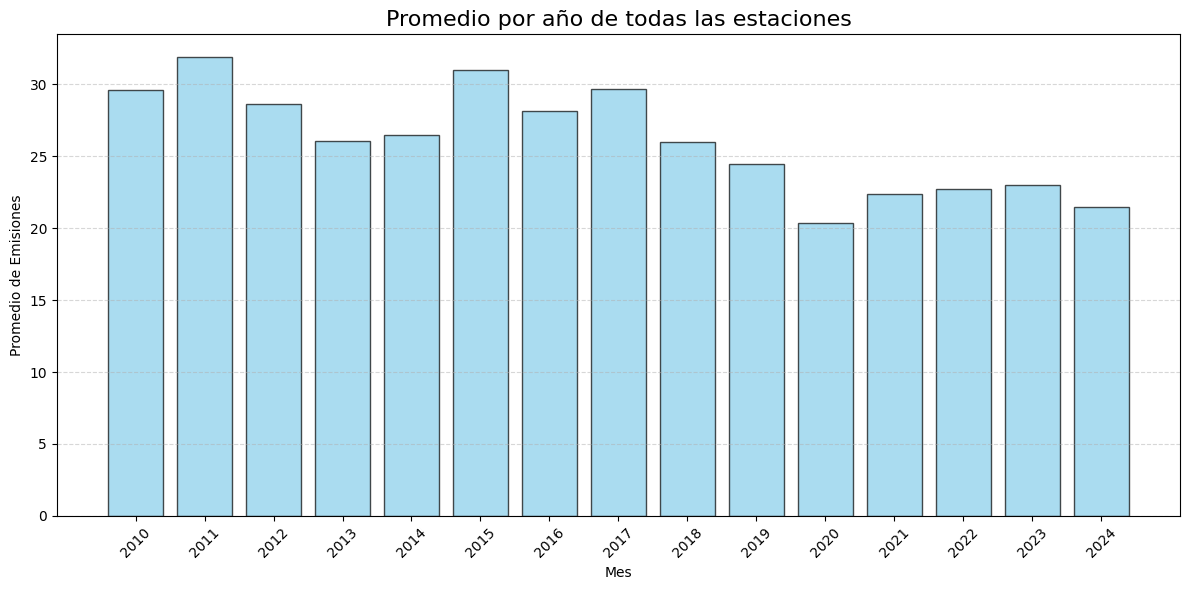

In [ ]:
promedio_anual = df.groupby(df['date'].dt.year)['D.1'].mean()

plt.figure(figsize=(12, 6))

plt.bar(promedio_anual.index, promedio_anual.values, color='skyblue', edgecolor='black', alpha=0.7)


plt.xticks(promedio_anual.index, rotation=45)
plt.title('Promedio por año de todas las estaciones', fontsize=16)
plt.xlabel('Mes')
plt.ylabel('Promedio de Emisiones')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [ ]:

"""
# Promedio
promedio_semanal = df.groupby('dia_semana')['D.1'].mean()
plt.figure(figsize=(12, 6))

plt.bar(promedio_semanal.index, promedio_semanal.values, color='green', edgecolor='black', alpha=0.7)


nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.xticks(promedio_semanal.index, nombres_dias, rotation=45)
plt.title('Promedio por dia de la semana de todas las estaciones', fontsize=16)
plt.xlabel('Mes')
plt.ylabel('Promedio de Emisiones')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()"""

"\n# Promedio\npromedio_semanal = df.groupby('dia_semana')['D.1'].mean()\nplt.figure(figsize=(12, 6))\n\nplt.bar(promedio_semanal.index, promedio_semanal.values, color='green', edgecolor='black', alpha=0.7)\n\n\nnombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']\nplt.xticks(promedio_semanal.index, nombres_dias, rotation=45)\nplt.title('Promedio por dia de la semana de todas las estaciones', fontsize=16)\nplt.xlabel('Mes')\nplt.ylabel('Promedio de Emisiones')\nplt.grid(axis='y', linestyle='--', alpha=0.5)\nplt.tight_layout()\n\nplt.show()"

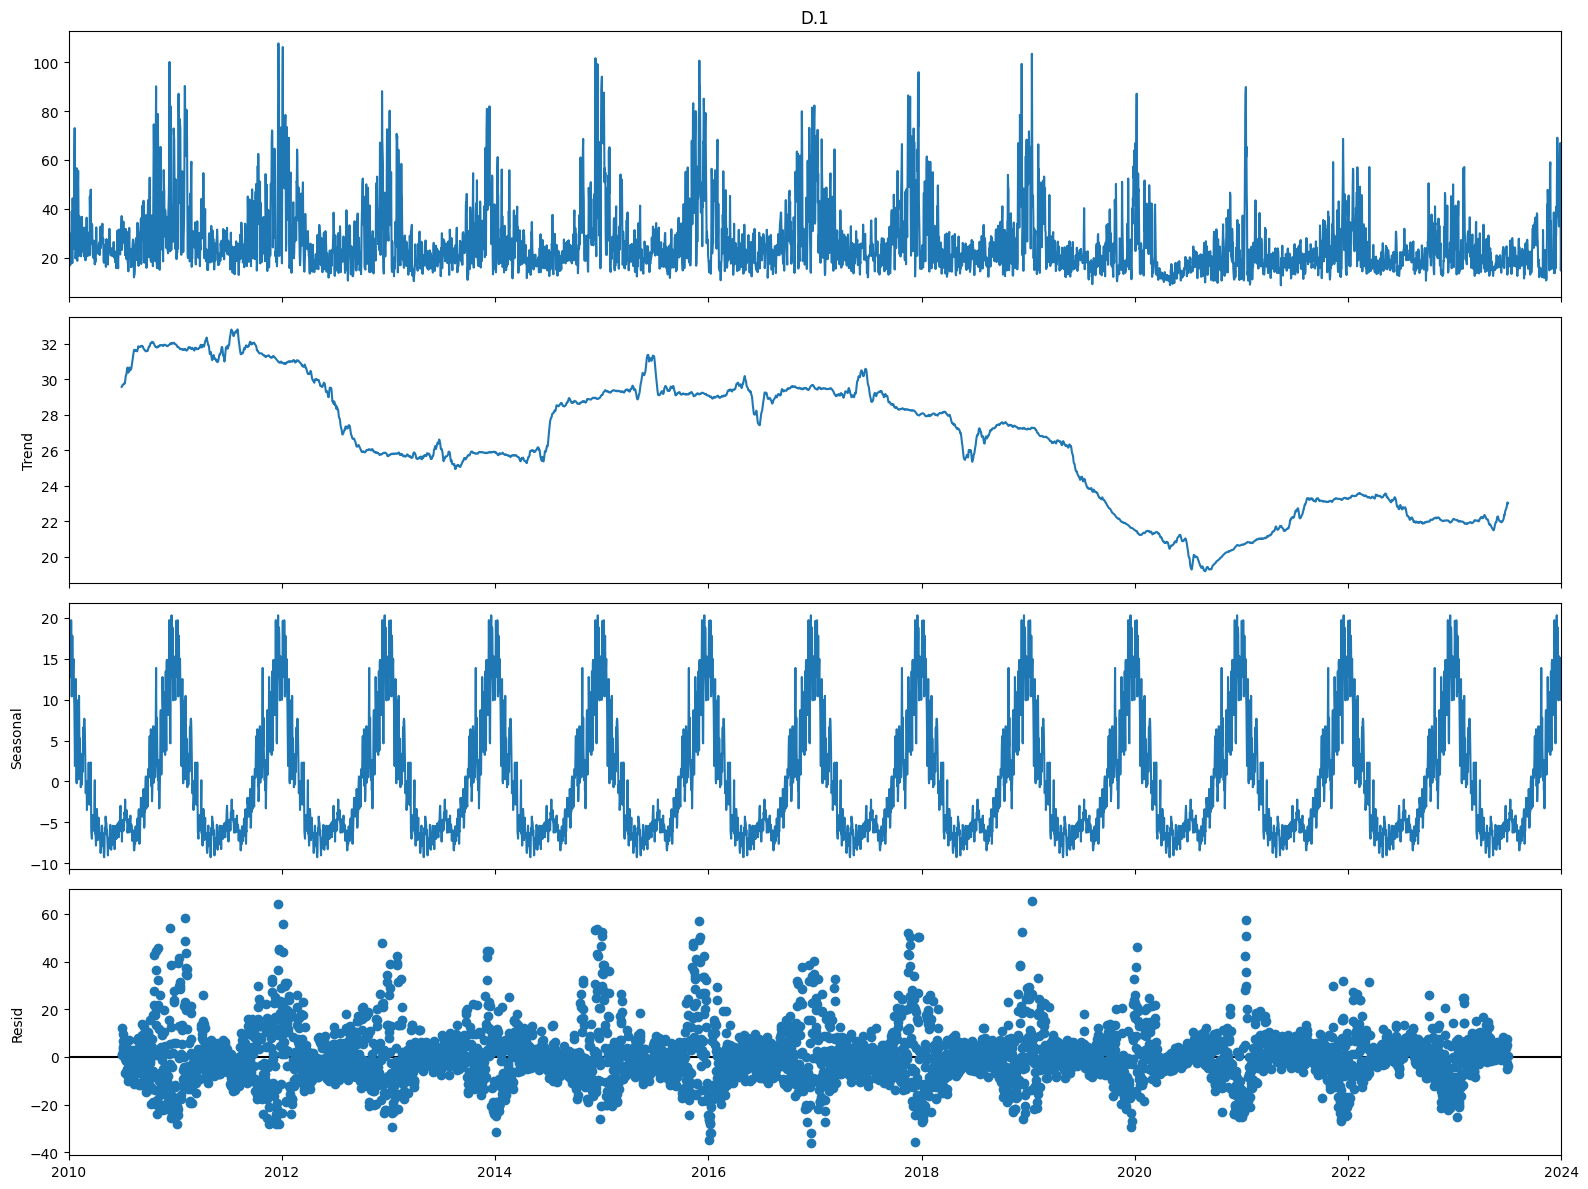

In [ ]:
#Dataset agrupando por dia,
diario = df.groupby('date')['D.1'].mean()

# Filtro datos
mask_year = (diario.index >= '2010') & (diario.index <= '2024')
datos_limpios = diario.loc[mask_year]

# Descmomposcion anual de los datos
result = sm.tsa.seasonal_decompose(datos_limpios.dropna(), model='additive', period=365)

# Grafica
fig = result.plot()
fig.set_size_inches(16, 12)
plt.tight_layout()
plt.show()

### Test ADF

In [ ]:
check_data =df.set_index('date')
mask_test = (check_data.index >= '2010') & (check_data.index <= '2024')

df_test_est_copy = check_data.loc[mask_test].copy()
df_test_est= df_test_est_copy['D.1'].dropna()
df_test_est.head()


date
2010-01-01    38.0
2010-01-01     9.0
2010-01-01    71.0
2010-01-01     2.0
2010-01-01     0.2
Name: D.1, dtype: float64

In [ ]:
dftest = adfuller(df_test_est, maxlag=50, autolag=None)

In [ ]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                         '#Lags Used',
                                         'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                    -44.564279
p-value                             0.000000
#Lags Used                         50.000000
Number of Observations Used    753834.000000
Critical Value (1%)                -3.430359
Critical Value (5%)                -2.861544
Critical Value (10%)               -2.566772
dtype: float64


In [ ]:
kpsstest = kpss(df_test_est)
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic             8.429469
p-value                    0.010000
Lags Used                444.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


In [ ]:
df_test_est.describe()

count    753885.000000
mean         26.562411
std          36.927029
min          -2.000000
25%           2.000000
50%          14.000000
75%          38.000000
max         498.000000
Name: D.1, dtype: float64

In [ ]:
df

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  \
299553          28         79        39        12   28079039_12_8  2010   
298809          28         79        39         7    28079039_7_8  2010   
309411          28         79        54        14   28079054_14_6  2010   
283557          28         79        24         7    28079024_7_8  2010   
315735          28         79        57         6   28079057_6_48  2010   
...            ...        ...       ...       ...             ...   ...   
1079562         28         79        36         8    28079036_8_8  2024   
1079531         28         79        36         7    28079036_7_8  2024   
1079500         28         79        36         1   28079036_1_38  2024   
1079748         28         79        38        10  28079038_10_47  2024   
1081794         28         79        60        14   28079060_14_6  2024   

         month  day    D.1  V FUENTE_ARCHIVO       date  
299553       1    1  38.00  V    datos10.csv 2010-01-01  
298809       1    1   9.00  V    datos10.csv 2010-01-01  
309411       1    1  71.00  V    datos10.csv 2010-01-01  
283557       1    1   2.00  V    datos10.csv 2010-01-01  
315735       1    1   0.20  V    datos10.csv 2010-01-01  
...        ...  ...    ... ..            ...        ...  
1079562     12   31  41.96  V    datos24.csv 2024-12-31  
1079531     12   31  14.33  V    datos24.csv 2024-12-31  
1079500     12   31   2.63  V    datos24.csv 2024-12-31  
1079748     12   31  15.08  V    datos24.csv 2024-12-31  
1081794     12   31  35.13  V    datos24.csv 2024-12-31  

[800683 rows x 12 columns]

#LTSM


##Busqueda de hiper


In [ ]:
def create_dataset(y, h=1, seq_len=30, batch_size=32,
                   scaler=None, fit_scaler=False):

    if scaler is None:
        scaler = MinMaxScaler()
        fit_scaler = True

    y_array = np.array(y).reshape(-1, 1)

    y_log = np.log1p(y_array)
    if fit_scaler:
        y_scaled = scaler.fit_transform(y_log).flatten()
    else:
        y_scaled = scaler.transform(y_log).flatten()
    X, y_target = [], []
    for i in range(len(y_scaled) - seq_len - h + 1):
        X.append(y_scaled[i:i + seq_len])
        y_target.append(y_scaled[i + seq_len + h - 1])

    X = np.array(X).reshape((-1, seq_len, 1))
    y_target = np.array(y_target)

    dataset = tf.data.Dataset.from_tensor_slices((X, y_target))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, scaler



In [ ]:
def inverse_transform(values, transformer):

    values_minmax = transformer['scaler'].inverse_transform(
        values.reshape(-1, 1)
    )
    values_original = transformer['yj'].inverse_transform(values_minmax)
    return values_original.flatten()

In [ ]:
"""
# hiperpametros de busqueda

def build_and_search(seq_len, scaler_type, patience_trials=10):

    base_scaler = MinMaxScaler()


    dataset_tr, scaler = create_dataset(y_train, h=1, seq_len=seq_len, batch_size=32, fit_scaler=True)
    dataset_va, _ = create_dataset(y_val, h=1, seq_len=seq_len, batch_size=32, scaler=scaler, fit_scaler=False)

    def build_model(hp):
        set_random_seed(123)

        units_1 = hp.Choice('units_1', [64, 128, 256])
        units_2 = hp.Choice('units_2', [32, 64, 128])

        dropout_1 = hp.Float('dropout_1', 0.05, 0.30, step=0.05)
        dropout_2 = hp.Float('dropout_2', 0.05, 0.30, step=0.05)
        dropout_3 = hp.Float('dropout_3', 0.05, 0.20, step=0.05)

        kernel_reg = hp.Choice('kernel_reg', [0.0, 0.0001, 0.0005, 0.001])

        lr = hp.Choice('lr', [1e-4, 5e-4, 1e-3])
        dense_units = hp.Choice('dense_units', [16, 32, 64])

        # Arquitectura: 2 capas (Bi-LSTM + LSTM)
        model = Sequential([
            Bidirectional(
                LSTM(
                    units_1,
                    return_sequences=True,
                    kernel_regularizer=l2(kernel_reg) if kernel_reg > 0 else None
                ),
                input_shape=(seq_len, 1)
            ),
            Dropout(dropout_1),

            LSTM(
                units_2,
                return_sequences=False,
                kernel_regularizer=l2(kernel_reg) if kernel_reg > 0 else None
            ),
            Dropout(dropout_2),

            Dense(dense_units, activation='relu'),
            Dropout(dropout_3),
            Dense(1)
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    tuner = kt.BayesianOptimization(
        build_model,
        objective='val_mae',
        max_trials=25,
        directory='tuner_results',
        project_name=f'lstm_co2_seq{seq_len}_log1p_minmax',
        max_consecutive_failed_trials=patience_trials
    )

    tuner.search(
        dataset_tr,
        validation_data=dataset_va,
        epochs=50,  # Aumentado de 25 a 50 para mejor convergencia
        callbacks=[EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True)],
        verbose=1
    )


    all_trials_data = []
    for trial in tuner.oracle.trials.values():
        if trial.score is not None:
            hp = trial.hyperparameters.values
            all_trials_data.append({
                'trial_id': trial.trial_id,
                'seq_len': seq_len,
                'scaler_type': 'log1p_minmax',  # Siempre este
                'units_1': hp.get('units_1'),
                'units_2': hp.get('units_2'),
                'dropout_1': hp.get('dropout_1'),
                'dropout_2': hp.get('dropout_2'),
                'dropout_3': hp.get('dropout_3'),
                'kernel_reg': hp.get('kernel_reg'),
                'dense_units': hp.get('dense_units'),
                'lr': hp.get('lr'),
                'val_mae': trial.score  # Cambiado de val_loss a val_mae
            })

    best_hps = tuner.get_best_hyperparameters()[0]
    best_mae = tuner.get_best_models()[0].evaluate(dataset_va, verbose=0)[1]  # [loss, mae]

    return {
        'best': {
            'seq_len': seq_len,
            'scaler_type': 'log1p_minmax',
            'units_1': best_hps.get('units_1'),
            'units_2': best_hps.get('units_2'),
            'dropout_1': best_hps.get('dropout_1'),
            'dropout_2': best_hps.get('dropout_2'),
            'dropout_3': best_hps.get('dropout_3'),
            'kernel_reg': best_hps.get('kernel_reg'),
            'dense_units': best_hps.get('dense_units'),
            'lr': best_hps.get('lr'),
            'val_mae': best_mae
        },
        'all_trials': all_trials_data
    }
"""



In [ ]:
"""

# Ejecutar busqueda

all_trials_combined = []
best_results = []
seq_lengths = [ 60]
scaler_types = ['minmax']
total_combinations = len(seq_lengths) * len(scaler_types)
current = 0

for seq_len in seq_lengths:
    for scaler_type in scaler_types:
        current += 1
        print(f"\n{'='*60}")
        print(f"[{current}/{total_combinations}] BUSCANDO: seq_len={seq_len} días, transform=Log1p+MinMax")
        print('='*60)

        result = build_and_search(seq_len, scaler_type, patience_trials=10)

        best_results.append(result['best'])
        all_trials_combined.extend(result['all_trials'])

        print(f"\nMejor para esta combinación: val_mae={result['best']['val_mae']:.6f}")
        print(f"   Units: [{result['best']['units_1']}, {result['best']['units_2']}]")
        print(f"   Dropout: [{result['best']['dropout_1']:.2f}, {result['best']['dropout_2']:.2f}, {result['best']['dropout_3']:.2f}]")
        print(f"   L2 reg: {result['best']['kernel_reg']}")
        print(f"   LR: {result['best']['lr']}")
        print(f"   Total trials completados: {len(result['all_trials'])}")
"""


In [ ]:

"""

# Resultados

df_all_trials = pd.DataFrame(all_trials_combined)
df_all_trials = df_all_trials.sort_values('val_mae')  # Cambiado de val_loss a val_mae
df_all_trials['rank'] = range(1, len(df_all_trials) + 1)
df_all_trials.to_csv('all_trials_results_log1p_minmax.csv', index=False)

print("\n" + "="*60)
print(f"TODOS LOS TRIALS ({len(df_all_trials)} completados)")
print("="*60)

"""


##Modelo definido


In [ ]:

# Definicion final

def create_dataset(y, h=1, seq_len=30, batch_size=32,
                   scaler=None, fit_scaler=False):

    if scaler is None:
        scaler = MinMaxScaler()
        fit_scaler = True

    y_array = np.array(y).reshape(-1, 1)

    y_log = np.log1p(y_array)

    if fit_scaler:
        y_scaled = scaler.fit_transform(y_log).flatten()
    else:
        y_scaled = scaler.transform(y_log).flatten()

    X, y_target = [], []
    for i in range(len(y_scaled) - seq_len - h + 1):
        X.append(y_scaled[i:i + seq_len])
        y_target.append(y_scaled[i + seq_len + h - 1])

    X = np.array(X).reshape((-1, seq_len, 1))
    y_target = np.array(y_target)

    dataset = tf.data.Dataset.from_tensor_slices((X, y_target))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, scaler, X, y_target


In [ ]:
def inverse_transform(y_scaled, scaler):

    y_log = scaler.inverse_transform(y_scaled.reshape(-1, 1))

    y_original = np.expm1(y_log)
    return y_original.flatten()

In [ ]:

#Modelo

def create_lstm_model(seq_len=60):
    model = Sequential([
        Bidirectional(
            LSTM(
                256,
                return_sequences=True,
                kernel_regularizer=l2(0.0)
            ),
            input_shape=(seq_len, 1)
        ),
        Dropout(0.15),

        LSTM(
            64,
            return_sequences=False,
            kernel_regularizer=l2(0.0)
        ),
        Dropout(0.1),

        Dense(64, activation='relu'),
        Dropout(0.20),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


SEQ_LEN = 60
BATCH_SIZE = 32


##Global

###Segmentar dataset



In [ ]:
df = df.set_index('date')


In [ ]:
df_global = df

In [ ]:
df_global = df_global[[ 'D.1']]

In [ ]:
df_global = df_global.groupby(level=0).mean()

In [ ]:
df_global_2025 = df_2025.set_index('date')


In [ ]:
df_global_2025 = df_global_2025[[ 'D.1']]


In [ ]:
df_global_2025= df_global_2025.groupby(level=0).mean()

In [ ]:
df_total_global = pd.concat([df_global, df_global_2025])
df_total_global.index = pd.to_datetime(df_total_global.index)
type(df_total_global.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
# Ordenar el índice cronológicamente
df_total_global = df_total_global.sort_index()

# Ahora sí puedes hacer el slicing
y_train = df_total_global['2010':'2023']
y_val = df_total_global['2024':'2024']
y_test = df_total_global['2025':'2025']

# Verificar tamaños
print(f"y_train: {len(y_train)} días ({y_train.index.min()} a {y_train.index.max()})")
print(f"y_val: {len(y_val)} días ({y_val.index.min()} a {y_val.index.max()})")
print(f"y_test: {len(y_test)} días ({y_test.index.min()} a {y_test.index.max()})")

y_train: 5113 días (2010-01-01 00:00:00 a 2023-12-31 00:00:00)
y_val: 366 días (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
y_test: 365 días (2025-01-01 00:00:00 a 2025-12-31 00:00:00)


###Modelo

In [ ]:
# Entrenamiento
SEQ_LEN = 30
horizontes = [1,7,14,30]


resultados = []

callbacks = [
    EarlyStopping(
        monitor='val_mae',
        patience=30,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001
    ),
    ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=15,
        min_lr=1e-7,
        verbose=1
    )
]

for h in horizontes:
    print(f"\n{'='*70}")
    print(f"HORIZONTE H={h} DÍAS")
    print(f"{'='*70}")

    # Modelo
    model = create_lstm_model(seq_len=SEQ_LEN)

    dataset_tr, scaler, _, _ = create_dataset(
        y_train, h=h, seq_len=SEQ_LEN, fit_scaler=True
    )
    dataset_va, _, _, _ = create_dataset(
        y_val, h=h, seq_len=SEQ_LEN, scaler=scaler, fit_scaler=False
    )
    dataset_te, _, X_te, y_te_scaled = create_dataset(
        y_test, h=h, seq_len=SEQ_LEN, scaler=scaler, fit_scaler=False
    )

    # Entrenar
    print("Entrenando...")
    history = model.fit(
        dataset_tr,
        validation_data=dataset_va,
        epochs=200,
        callbacks=callbacks,
        verbose=2
    )

    # Predecir
    print("Prediciendo...")
    preds_scaled = model.predict(X_te, verbose=0)

    preds = inverse_transform(preds_scaled, scaler)
    y_te = inverse_transform(y_te_scaled, scaler)

    # Métricas
    mae = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    r2 = r2_score(y_te, preds)

    # Baseline
    naive_mae = calculate_naive_baseline(y_test.values.flatten(), h)
    mejora = (naive_mae - mae) / naive_mae * 100

    # Varianza
    var_preds = np.var(preds)
    var_real = np.var(y_te)
    var_ratio = var_preds / var_real

    # Guardar
    resultados.append({
        'h': h,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'naive_mae': naive_mae,
        'mejora': mejora,
        'var_ratio': var_ratio,
        'preds': preds,
        'y_true': y_te
    })

    # Reportar
    print(f"\n RESULTADOS H={h}:")
    print(f"   MAE:              {mae:.4f}")
    print(f"   RMSE:             {rmse:.4f}")
    print(f"   R²:               {r2:.4f}")
    print(f"   Naive baseline:   {naive_mae:.4f}")
    print(f"   Mejora:           {mejora:+.1f}%")
    print(f"   Var pred/real:    {var_preds:.2f} / {var_real:.2f} (ratio: {var_ratio:.2f})")

    # Diagnóstico
    print(f"\n🔍 Diagnóstico:")
    print(f"   Preds  → min:{preds.min():.2f}, max:{preds.max():.2f}, mean:{preds.mean():.2f}, std:{preds.std():.2f}")
    print(f"   Reales → min:{y_te.min():.2f}, max:{y_te.max():.2f}, mean:{y_te.mean():.2f}, std:{y_te.std():.2f}")




HORIZONTE H=1 DÍAS
Entrenando...
Epoch 1/200
159/159 - 5s - 32ms/step - loss: 0.0268 - mae: 0.1250 - val_loss: 0.0118 - val_mae: 0.0867 - learning_rate: 5.0000e-04
Epoch 2/200
159/159 - 2s - 13ms/step - loss: 0.0192 - mae: 0.1068 - val_loss: 0.0108 - val_mae: 0.0830 - learning_rate: 5.0000e-04
Epoch 3/200
159/159 - 1s - 9ms/step - loss: 0.0178 - mae: 0.1030 - val_loss: 0.0100 - val_mae: 0.0800 - learning_rate: 5.0000e-04
Epoch 4/200
159/159 - 1s - 9ms/step - loss: 0.0166 - mae: 0.0991 - val_loss: 0.0099 - val_mae: 0.0801 - learning_rate: 5.0000e-04
Epoch 5/200
159/159 - 1s - 9ms/step - loss: 0.0164 - mae: 0.0993 - val_loss: 0.0096 - val_mae: 0.0790 - learning_rate: 5.0000e-04
Epoch 6/200
159/159 - 2s - 12ms/step - loss: 0.0160 - mae: 0.0977 - val_loss: 0.0092 - val_mae: 0.0772 - learning_rate: 5.0000e-04
Epoch 7/200
159/159 - 2s - 13ms/step - loss: 0.0152 - mae: 0.0948 - val_loss: 0.0091 - val_mae: 0.0764 - learning_rate: 5.0000e-04
Epoch 8/200
159/159 - 1s - 9ms/step - loss: 0.0148 -

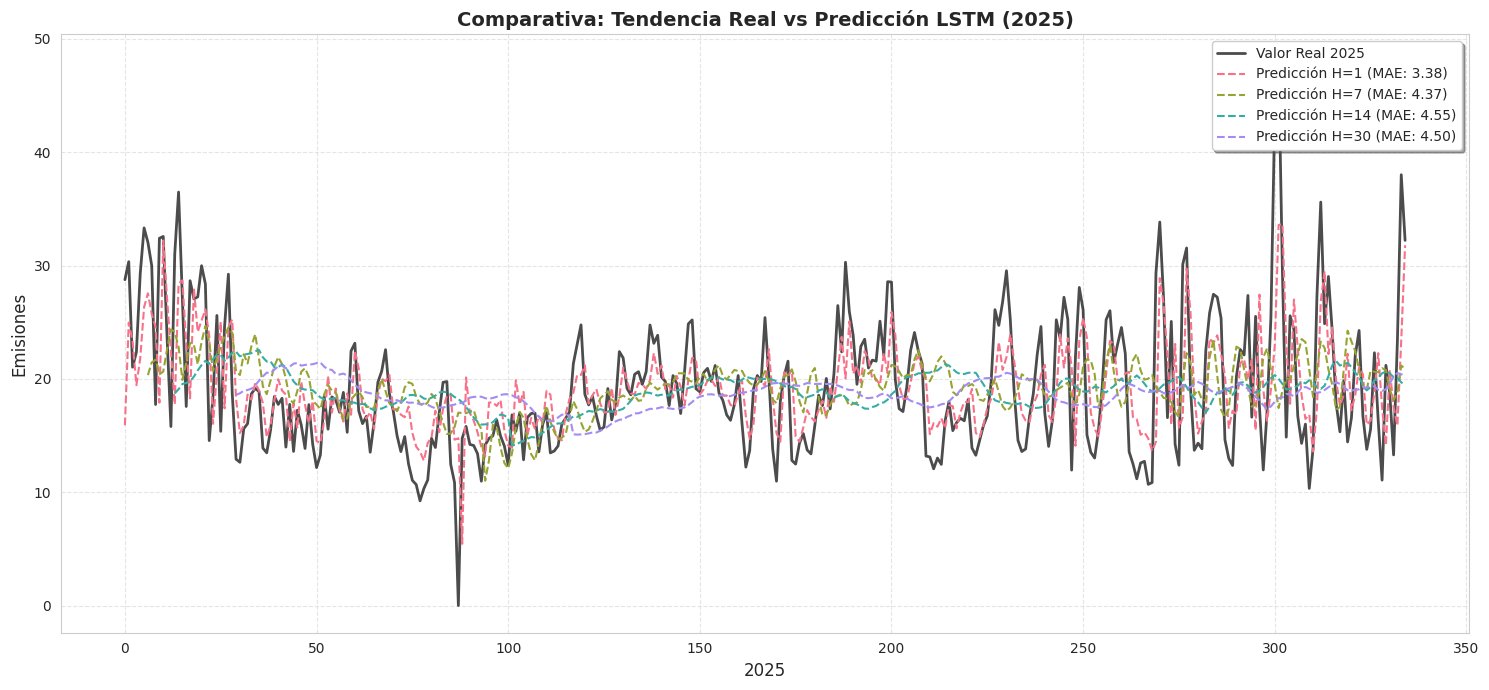

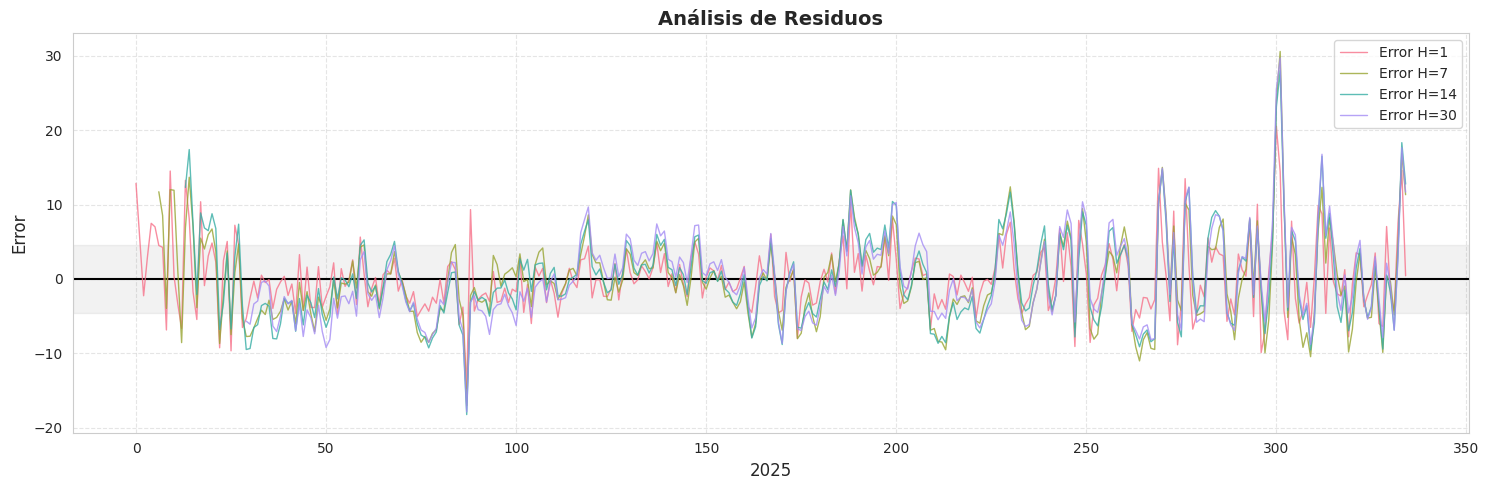

In [ ]:
#Graficos
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
colores = sns.color_palette("husl", len(resultados))

if len(resultados) > 0:
    y_real_base = resultados[0]['y_true']
#Horizontes prediccion
    plt.figure(figsize=(15, 7))


    plt.plot(y_real_base, label='Valor Real 2025', color='black', linewidth=2, alpha=0.7)


    for i, res in enumerate(resultados):
        h = res['h']
        preds = res['preds']

        diferencia_len = len(y_real_base) - len(preds)

        if diferencia_len == 0:
            plt.plot(preds, label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)
        else:
            plt.plot(range(diferencia_len, len(y_real_base)), preds,
                     label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)

    plt.title('Comparativa: Tendencia Real vs Predicción LSTM (2025)', fontsize=14, fontweight='bold')
    plt.ylabel('Emisiones', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

  #Residuos
    plt.figure(figsize=(15, 5))

    plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

    for i, res in enumerate(resultados):
        h = res['h']
        preds = res['preds']

        diferencia_len = len(y_real_base) - len(preds)


        if diferencia_len == 0:
            residuo = y_real_base - preds
            plt.plot(residuo, label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)
        else:

            y_real_recortado = y_real_base[diferencia_len:]
            residuo = y_real_recortado - preds
            plt.plot(range(diferencia_len, len(y_real_base)), residuo,
                     label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)

    plt.title('Análisis de Residuos', fontsize=14, fontweight='bold')
    plt.ylabel('Error', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True)

    std_error = (y_real_base - resultados[0]['preds']).std() if len(resultados) > 0 else 0
    plt.axhspan(-std_error, std_error, color='gray', alpha=0.1, label='±1 Desviación Std del Error')

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()

In [ ]:

#Resumen

print(f"\n{'='*70}")
print("RESUMEN FINAL")
print(f"{'='*70}")
print(f"{'Horizonte':<12} {'MAE':<10} {'R²':<10} {'Mejora':<12} {'Var ratio':<10}")
print(f"{'-'*70}")

for r in resultados:
    print(f"H={r['h']:2d} días    {r['mae']:7.4f}    {r['r2']:7.4f}    {r['mejora']:+6.1f}%      {r['var_ratio']:7.2f}")

print(f"{'='*70}")


RESUMEN FINAL
Horizonte    MAE        R²         Mejora       Var ratio 
----------------------------------------------------------------------
H= 1 días     3.3847     0.4183     +15.1%         0.38
H= 7 días     4.3713     0.0631     +28.6%         0.14
H=14 días     4.5535    -0.0150     +26.1%         0.07
H=30 días     4.5018    -0.0488     +29.3%         0.05


##Estacion 35

###Segmentar dataset



In [ ]:
df_35 = df[df["ESTACION"] == 35]
df_35

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO  year  \
date                                                                        
2010-01-01         28         79        35         8   28079035_8_8  2010   
2010-01-01         28         79        35        12  28079035_12_8  2010   
2010-01-01         28         79        35        14  28079035_14_6  2010   
2010-01-01         28         79        35         1  28079035_1_38  2010   
2010-01-01         28         79        35         6  28079035_6_48  2010   
...               ...        ...       ...       ...            ...   ...   
2024-12-31         28         79        35         1  28079035_1_38  2024   
2024-12-31         28         79        35         7   28079035_7_8  2024   
2024-12-31         28         79        35         8   28079035_8_8  2024   
2024-12-31         28         79        35        14  28079035_14_6  2024   
2024-12-31         28         79        35        12  28079035_12_8  2024   

            month  day    D.1  V FUENTE_ARCHIVO  
date                                             
2010-01-01      1    1  24.00  V    datos10.csv  
2010-01-01      1    1  34.00  V    datos10.csv  
2010-01-01      1    1  58.00  V    datos10.csv  
2010-01-01      1    1  10.00  V    datos10.csv  
2010-01-01      1    1   0.30  V    datos10.csv  
...           ...  ...    ... ..            ...  
2024-12-31     12   31   5.17  V    datos24.csv  
2024-12-31     12   31  13.50  V    datos24.csv  
2024-12-31     12   31  40.88  V    datos24.csv  
2024-12-31     12   31  28.63  V    datos24.csv  
2024-12-31     12   31  61.58  V    datos24.csv  

[32508 rows x 11 columns]

In [ ]:
df_35 = df_35[[ 'D.1']]

In [ ]:
df_35 = df_35.groupby(level=0).mean()
df_35

D.1
date                 
2010-01-01  22.050000
2010-01-02  32.400000
2010-01-03  45.266667
2010-01-04  48.933333
2010-01-05  36.083333
...               ...
2024-12-27  23.760000
2024-12-28  26.041667
2024-12-29  23.895000
2024-12-30  30.111667
2024-12-31  25.045000

[5418 rows x 1 columns]

In [ ]:
df_35_2025 = df_2025[df_2025["ESTACION"] == 35]
df_35_2025 = df_35_2025.set_index('date')


In [ ]:
df_35_2025

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO  year  \
date                                                                        
2025-01-01         28         79        35         1  28079035_1_38  2025   
2025-01-01         28         79        35        12  28079035_12_8  2025   
2025-01-01         28         79        35        14  28079035_14_6  2025   
2025-01-01         28         79        35         6  28079035_6_48  2025   
2025-01-01         28         79        35         7   28079035_7_8  2025   
...               ...        ...       ...       ...            ...   ...   
2025-12-31         28         79        35        12  28079035_12_8  2025   
2025-12-31         28         79        35        14  28079035_14_6  2025   
2025-12-31         28         79        35         6  28079035_6_48  2025   
2025-12-31         28         79        35         7   28079035_7_8  2025   
2025-12-31         28         79        35         8   28079035_8_8  2025   

            month  day   D.1  V FUENTE_ARCHIVO  
date                                            
2025-01-01      1    1   5.0  V    datos25.csv  
2025-01-01      1    1  62.0  V    datos25.csv  
2025-01-01      1    1  28.0  V    datos25.csv  
2025-01-01      1    1   0.5  V    datos25.csv  
2025-01-01      1    1  15.0  V    datos25.csv  
...           ...  ...   ... ..            ...  
2025-12-31     12   31  88.0  V    datos25.csv  
2025-12-31     12   31  19.0  V    datos25.csv  
2025-12-31     12   31   0.6  V    datos25.csv  
2025-12-31     12   31  27.0  V    datos25.csv  
2025-12-31     12   31  47.0  V    datos25.csv  

[2190 rows x 11 columns]

In [ ]:
df_35_2025 = df_35_2025[[ 'D.1']]
df_35_2025.head()

D.1
date            
2025-01-01   5.0
2025-01-01  62.0
2025-01-01  28.0
2025-01-01   0.5
2025-01-01  15.0

In [ ]:
df_35_2025= df_35_2025.groupby(level=0).mean()
df_35_2025.head()

D.1
date                 
2025-01-01  24.750000
2025-01-02  32.433333
2025-01-03  28.583333
2025-01-04  26.083333
2025-01-05  17.733333

In [ ]:
df_total_35 = pd.concat([df_35, df_35_2025])
df_total_35.index = pd.to_datetime(df_total_35.index)
type(df_total_35.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:

df_total_35 = df_total_35.sort_index()

y_train = df_total_35['2010':'2023']
y_val = df_total_35['2024':'2024']
y_test = df_total_35['2025':]

# Check
print(f"y_train: {len(y_train)} días ({y_train.index.min()} a {y_train.index.max()})")
print(f"y_val: {len(y_val)} días ({y_val.index.min()} a {y_val.index.max()})")
print(f"y_test: {len(y_test)} días ({y_test.index.min()} a {y_test.index.max()})")

y_train: 5052 días (2010-01-01 00:00:00 a 2023-12-31 00:00:00)
y_val: 366 días (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
y_test: 365 días (2025-01-01 00:00:00 a 2025-12-31 00:00:00)


###Modelo

In [ ]:
# Entrenamiento

SEQ_LEN = 30
horizontes = [1,7,14,30]

resultados = []

callbacks = [
    EarlyStopping(
        monitor='val_mae',
        patience=30,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001
    ),
    ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=15,
        min_lr=1e-7,
        verbose=1
    )
]

for h in horizontes:
    print(f"\n{'='*70}")
    print(f"HORIZONTE H={h} DÍAS")
    print(f"{'='*70}")

    # Crear modelo
    model = create_lstm_model(seq_len=SEQ_LEN)

    # Datasets
    dataset_tr, scaler, _, _ = create_dataset(
        y_train, h=h, seq_len=SEQ_LEN, fit_scaler=True
    )
    dataset_va, _, _, _ = create_dataset(
        y_val, h=h, seq_len=SEQ_LEN, scaler=scaler, fit_scaler=False
    )
    dataset_te, _, X_te, y_te_scaled = create_dataset(
        y_test, h=h, seq_len=SEQ_LEN, scaler=scaler, fit_scaler=False
    )

    # Entrenar
    print("Entrenando...")
    history = model.fit(
        dataset_tr,
        validation_data=dataset_va,
        epochs=200,
        callbacks=callbacks,
        verbose=2
    )

    # Predecir
    print("Prediciendo...")
    preds_scaled = model.predict(X_te, verbose=0)

    # Inverse transform
    preds = inverse_transform(preds_scaled, scaler)
    y_te = inverse_transform(y_te_scaled, scaler)

    # Métricas
    mae = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    r2 = r2_score(y_te, preds)

    # Baseline
    naive_mae = calculate_naive_baseline(y_test.values.flatten(), h)
    mejora = (naive_mae - mae) / naive_mae * 100

    # Varianza
    var_preds = np.var(preds)
    var_real = np.var(y_te)
    var_ratio = var_preds / var_real

    # Guardar
    resultados.append({
        'h': h,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'naive_mae': naive_mae,
        'mejora': mejora,
        'var_ratio': var_ratio,
        'preds': preds,
        'y_true': y_te
    })

    # Reportar
    print(f"\n RESULTADOS H={h}:")
    print(f"   MAE:              {mae:.4f}")
    print(f"   RMSE:             {rmse:.4f}")
    print(f"   R²:               {r2:.4f}")
    print(f"   Naive baseline:   {naive_mae:.4f}")
    print(f"   Mejora:           {mejora:+.1f}%")
    print(f"   Var pred/real:    {var_preds:.2f} / {var_real:.2f} (ratio: {var_ratio:.2f})")

    # Diagnóstico
    print(f"\nDiagnóstico:")
    print(f"   Preds  → min:{preds.min():.2f}, max:{preds.max():.2f}, mean:{preds.mean():.2f}, std:{preds.std():.2f}")
    print(f"   Reales → min:{y_te.min():.2f}, max:{y_te.max():.2f}, mean:{y_te.mean():.2f}, std:{y_te.std():.2f}")



In [ ]:
#Mejores resultados

print(f"\n{'='*70}")
print("📈 RESUMEN FINAL")
print(f"{'='*70}")
print(f"{'Horizonte':<12} {'MAE':<10} {'R²':<10} {'Mejora':<12} {'Var ratio':<10}")
print(f"{'-'*70}")

for r in resultados:
    print(f"H={r['h']:2d} días    {r['mae']:7.4f}    {r['r2']:7.4f}    {r['mejora']:+6.1f}%      {r['var_ratio']:7.2f}")

print(f"{'='*70}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Visualizacion
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
colores = sns.color_palette("husl", len(resultados))


if len(resultados) > 0:
    y_real_base = resultados[0]['y_true']

    plt.figure(figsize=(15, 7))

    plt.plot(y_real_base, label='Valor Real 2025', color='black', linewidth=2, alpha=0.7)


    for i, res in enumerate(resultados):
        h = res['h']
        preds = res['preds']

        diferencia_len = len(y_real_base) - len(preds)

        if diferencia_len == 0:
            plt.plot(preds, label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)
        else:
            plt.plot(range(diferencia_len, len(y_real_base)), preds,
                     label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)

    plt.title('Comparativa: Tendencia Real vs Predicción LSTM (2025)', fontsize=14, fontweight='bold')
    plt.ylabel('Emisiones', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))

    plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

    for i, res in enumerate(resultados):
        h = res['h']
        preds = res['preds']

        diferencia_len = len(y_real_base) - len(preds)

        if diferencia_len == 0:
            residuo = y_real_base - preds
            plt.plot(residuo, label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)
        else:

            y_real_recortado = y_real_base[diferencia_len:]
            residuo = y_real_recortado - preds
            plt.plot(range(diferencia_len, len(y_real_base)), residuo,
                     label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)

    plt.title('Análisis de Residuos', fontsize=14, fontweight='bold')
    plt.ylabel('Error', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True)

    std_error = (y_real_base - resultados[0]['preds']).std() if len(resultados) > 0 else 0
    plt.axhspan(-std_error, std_error, color='gray', alpha=0.1, label='±1 Desviación Std del Error')

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()

##Estacion 57

###Segmentar dataset



In [ ]:
df_57= df[df["ESTACION"] == 57]
df_57

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO  year  \
date                                                                         
2010-01-01         28         79        57         6   28079057_6_48  2010   
2010-01-01         28         79        57         7    28079057_7_8  2010   
2010-01-01         28         79        57        12   28079057_12_8  2010   
2010-01-01         28         79        57        10  28079057_10_47  2010   
2010-01-01         28         79        57         8    28079057_8_8  2010   
...               ...        ...       ...       ...             ...   ...   
2024-12-31         28         79        57        12   28079057_12_8  2024   
2024-12-31         28         79        57        10  28079057_10_47  2024   
2024-12-31         28         79        57         9   28079057_9_47  2024   
2024-12-31         28         79        57         8    28079057_8_8  2024   
2024-12-31         28         79        57         7    28079057_7_8  2024   

            month  day    D.1  V FUENTE_ARCHIVO  
date                                             
2010-01-01      1    1   0.20  V    datos10.csv  
2010-01-01      1    1   3.00  V    datos10.csv  
2010-01-01      1    1  21.00  V    datos10.csv  
2010-01-01      1    1   9.00  V    datos10.csv  
2010-01-01      1    1  16.00  V    datos10.csv  
...           ...  ...    ... ..            ...  
2024-12-31     12   31  38.33  V    datos24.csv  
2024-12-31     12   31  13.33  V    datos24.csv  
2024-12-31     12   31   9.21  V    datos24.csv  
2024-12-31     12   31  29.42  V    datos24.csv  
2024-12-31     12   31   5.75  V    datos24.csv  

[31809 rows x 11 columns]

In [ ]:
df_57 = df_57[[ 'D.1']]

In [ ]:
df_57 = df_57.groupby(level=0).mean()
df_57

D.1
date                 
2010-01-01   9.200000
2010-01-02  34.733333
2010-01-03  38.733333
2010-01-04  29.550000
2010-01-05  26.383333
...               ...
2024-12-27  18.024000
2024-12-28  33.068000
2024-12-29  25.866000
2024-12-30  27.894000
2024-12-31  19.208000

[5479 rows x 1 columns]

In [ ]:
df_57_2025 = df_2025[df_2025["ESTACION"] == 57]
df_57_2025 = df_57_2025.set_index('date')


In [ ]:
df_57_2025 = df_57_2025[[ 'D.1']]
df_57_2025.head()

D.1
date            
2025-01-01  17.0
2025-01-01  45.0
2025-01-01   9.0
2025-01-01  31.0
2025-01-01  14.0

In [ ]:
df_57_2025= df_57_2025.groupby(level=0).mean()
df_57_2025.head()

D.1
date            
2025-01-01  23.2
2025-01-02  29.6
2025-01-03  53.6
2025-01-04  28.2
2025-01-05  17.8

In [ ]:
df_total_57 = pd.concat([df_57, df_57_2025])
df_total_57.index = pd.to_datetime(df_total_57.index)
type(df_total_57.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:

df_total_57 = df_total_57.sort_index()


y_train = df_total_57['2010':'2023']
y_val = df_total_57['2024':'2024']
y_test = df_total_57['2025':]


print(f"y_train: {len(y_train)} días ({y_train.index.min()} a {y_train.index.max()})")
print(f"y_val: {len(y_val)} días ({y_val.index.min()} a {y_val.index.max()})")
print(f"y_test: {len(y_test)} días ({y_test.index.min()} a {y_test.index.max()})")

y_train: 5113 días (2010-01-01 00:00:00 a 2023-12-31 00:00:00)
y_val: 366 días (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
y_test: 365 días (2025-01-01 00:00:00 a 2025-12-31 00:00:00)


###Modelo

In [ ]:
# Entrenamiento

SEQ_LEN = 30
horizontes = [1,7,14,30]


resultados = []

callbacks = [
    EarlyStopping(
        monitor='val_mae',
        patience=30,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001
    ),
    ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=15,
        min_lr=1e-7,
        verbose=1
    )
]

for h in horizontes:
    print(f"\n{'='*70}")
    print(f"HORIZONTE H={h} DÍAS")
    print(f"{'='*70}")

    # Crear modelo
    model = create_lstm_model(seq_len=SEQ_LEN)

    # Datasets
    dataset_tr, scaler, _, _ = create_dataset(
        y_train, h=h, seq_len=SEQ_LEN, fit_scaler=True
    )
    dataset_va, _, _, _ = create_dataset(
        y_val, h=h, seq_len=SEQ_LEN, scaler=scaler, fit_scaler=False
    )
    dataset_te, _, X_te, y_te_scaled = create_dataset(
        y_test, h=h, seq_len=SEQ_LEN, scaler=scaler, fit_scaler=False
    )

    # Entrenar
    print("Entrenando...")
    history = model.fit(
        dataset_tr,
        validation_data=dataset_va,
        epochs=200,
        callbacks=callbacks,
        verbose=2
    )

    # Predecir
    print("Prediciendo...")
    preds_scaled = model.predict(X_te, verbose=0)

    # Inverse transform
    preds = inverse_transform(preds_scaled, scaler)
    y_te = inverse_transform(y_te_scaled, scaler)

    # Métricas
    mae = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    r2 = r2_score(y_te, preds)

    # Baseline
    naive_mae = calculate_naive_baseline(y_test.values.flatten(), h)
    mejora = (naive_mae - mae) / naive_mae * 100

    # Varianza
    var_preds = np.var(preds)
    var_real = np.var(y_te)
    var_ratio = var_preds / var_real

    # Guardar
    resultados.append({
        'h': h,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'naive_mae': naive_mae,
        'mejora': mejora,
        'var_ratio': var_ratio,
        'preds': preds,
        'y_true': y_te
    })

    # Reportar
    print(f"\n RESULTADOS H={h}:")
    print(f"   MAE:              {mae:.4f}")
    print(f"   RMSE:             {rmse:.4f}")
    print(f"   R²:               {r2:.4f}")
    print(f"   Naive baseline:   {naive_mae:.4f}")
    print(f"   Mejora:           {mejora:+.1f}%")
    print(f"   Var pred/real:    {var_preds:.2f} / {var_real:.2f} (ratio: {var_ratio:.2f})")

    # Diagnóstico
    print(f"\n🔍 Diagnóstico:")
    print(f"   Preds  → min:{preds.min():.2f}, max:{preds.max():.2f}, mean:{preds.mean():.2f}, std:{preds.std():.2f}")
    print(f"   Reales → min:{y_te.min():.2f}, max:{y_te.max():.2f}, mean:{y_te.mean():.2f}, std:{y_te.std():.2f}")




HORIZONTE H=1 DÍAS
Entrenando...
Epoch 1/200
159/159 - 5s - 30ms/step - loss: 0.0323 - mae: 0.1324 - val_loss: 0.0095 - val_mae: 0.0806 - learning_rate: 5.0000e-04
Epoch 2/200
159/159 - 2s - 14ms/step - loss: 0.0165 - mae: 0.1003 - val_loss: 0.0090 - val_mae: 0.0775 - learning_rate: 5.0000e-04
Epoch 3/200
159/159 - 2s - 10ms/step - loss: 0.0147 - mae: 0.0950 - val_loss: 0.0087 - val_mae: 0.0767 - learning_rate: 5.0000e-04
Epoch 4/200
159/159 - 1s - 9ms/step - loss: 0.0132 - mae: 0.0893 - val_loss: 0.0086 - val_mae: 0.0744 - learning_rate: 5.0000e-04
Epoch 5/200
159/159 - 1s - 9ms/step - loss: 0.0126 - mae: 0.0881 - val_loss: 0.0083 - val_mae: 0.0734 - learning_rate: 5.0000e-04
Epoch 6/200
159/159 - 1s - 9ms/step - loss: 0.0123 - mae: 0.0866 - val_loss: 0.0080 - val_mae: 0.0726 - learning_rate: 5.0000e-04
Epoch 7/200
159/159 - 1s - 9ms/step - loss: 0.0117 - mae: 0.0846 - val_loss: 0.0079 - val_mae: 0.0713 - learning_rate: 5.0000e-04
Epoch 8/200
159/159 - 1s - 9ms/step - loss: 0.0111 - 

In [ ]:

print(f"\n{'='*70}")
print("📈 RESUMEN FINAL")
print(f"{'='*70}")
print(f"{'Horizonte':<12} {'MAE':<10} {'R²':<10} {'Mejora':<12} {'Var ratio':<10}")
print(f"{'-'*70}")

for r in resultados:
    print(f"H={r['h']:2d} días    {r['mae']:7.4f}    {r['r2']:7.4f}    {r['mejora']:+6.1f}%      {r['var_ratio']:7.2f}")

print(f"{'='*70}")


📈 RESUMEN FINAL
Horizonte    MAE        R²         Mejora       Var ratio 
----------------------------------------------------------------------
H= 1 días     4.4757     0.3402     +19.5%         0.36
H= 7 días     5.5777     0.0973     +26.4%         0.15
H=14 días     5.7258     0.0124     +25.4%         0.10
H=30 días     5.4984    -0.0434     +30.8%         0.06


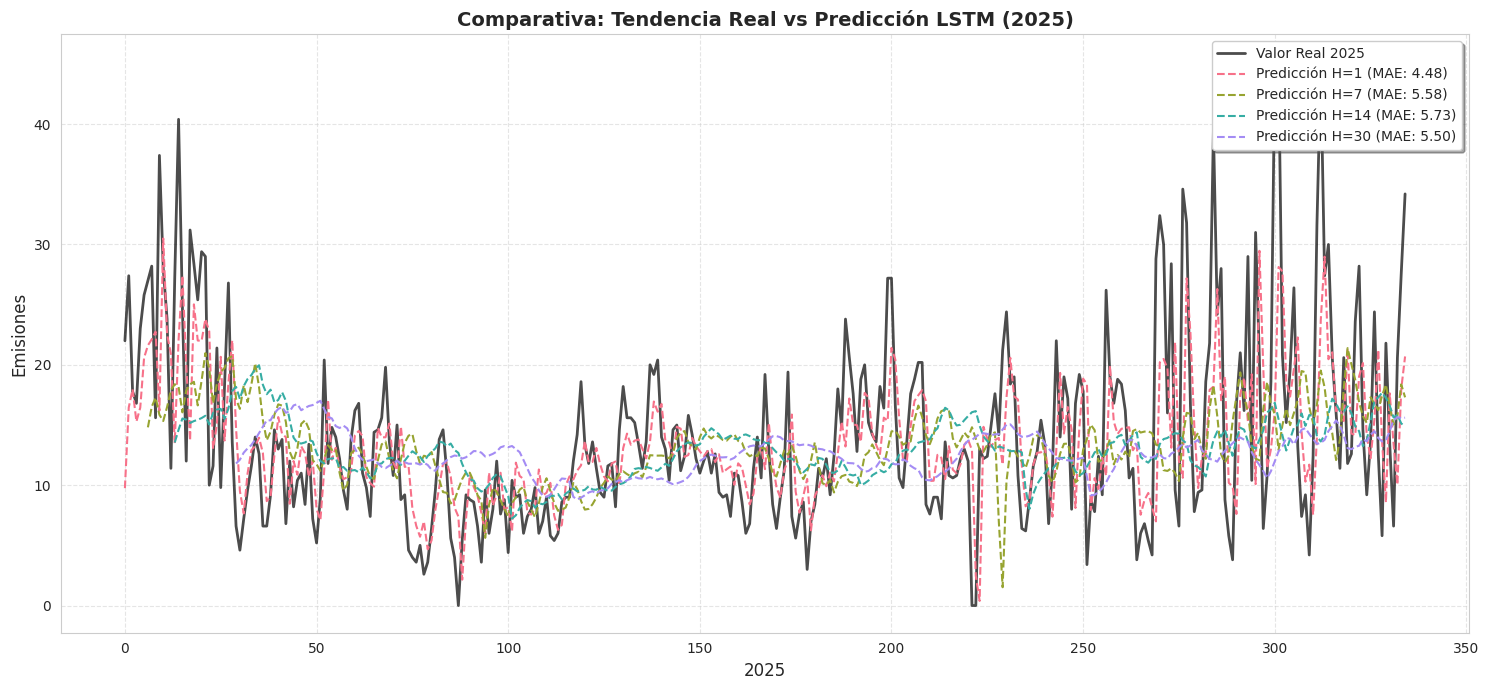

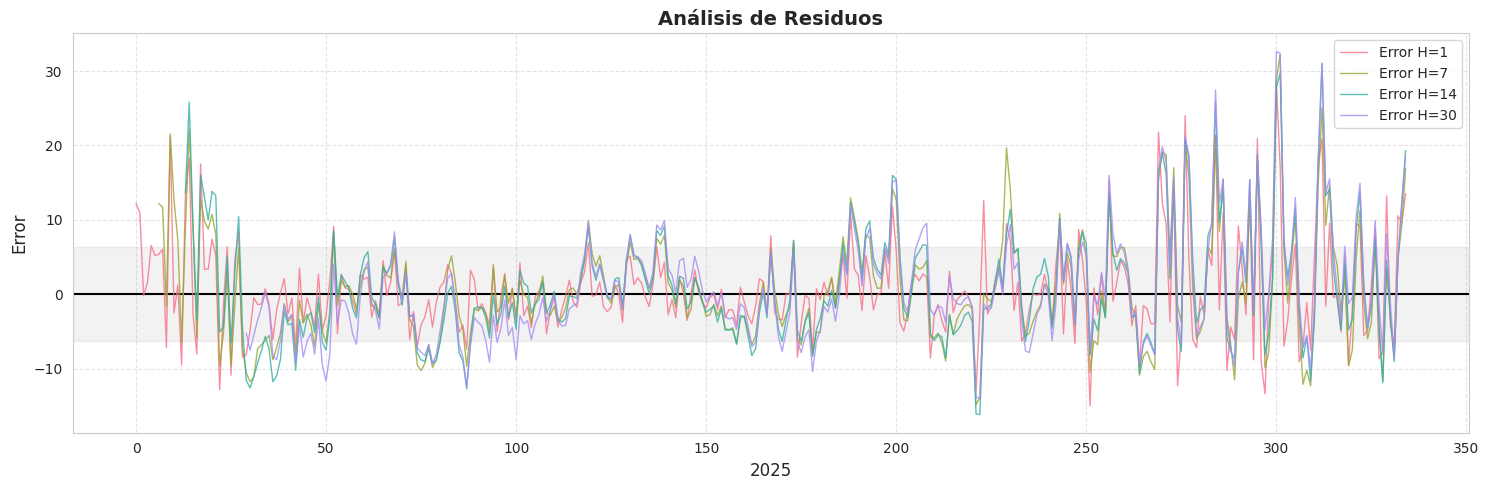

In [ ]:
# Visualizacion
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
colores = sns.color_palette("husl", len(resultados))


if len(resultados) > 0:
    y_real_base = resultados[0]['y_true']
    plt.figure(figsize=(15, 7))


    plt.plot(y_real_base, label='Valor Real 2025', color='black', linewidth=2, alpha=0.7)


    for i, res in enumerate(resultados):
        h = res['h']
        preds = res['preds']

        diferencia_len = len(y_real_base) - len(preds)

        if diferencia_len == 0:
            plt.plot(preds, label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)
        else:
            plt.plot(range(diferencia_len, len(y_real_base)), preds,
                     label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)

    plt.title('Comparativa: Tendencia Real vs Predicción LSTM (2025)', fontsize=14, fontweight='bold')
    plt.ylabel('Emisiones', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(15, 5))

    plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

    for i, res in enumerate(resultados):
        h = res['h']
        preds = res['preds']

        diferencia_len = len(y_real_base) - len(preds)


        if diferencia_len == 0:
            residuo = y_real_base - preds
            plt.plot(residuo, label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)
        else:
            y_real_recortado = y_real_base[diferencia_len:]
            residuo = y_real_recortado - preds
            plt.plot(range(diferencia_len, len(y_real_base)), residuo,
                     label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)

    plt.title('Análisis de Residuos', fontsize=14, fontweight='bold')
    plt.ylabel('Error', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True)

    std_error = (y_real_base - resultados[0]['preds']).std() if len(resultados) > 0 else 0
    plt.axhspan(-std_error, std_error, color='gray', alpha=0.1, label='±1 Desviación Std del Error')

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()

In [ ]:
promedio_57_test = df_57_2025['D.1'].mean()
print(promedio_57_test)

14.681095890410957


In [ ]:
promedio_25_test = df_2025['D.1'].mean()
print(promedio_25_test)

19.62498010471204


In [ ]:
promedio_35_test = df_35_2025['D.1'].mean()
print(promedio_35_test)

21.122374429223743


#SARIMA


In [ ]:
# Dataset
df_total_global = df_total_global.sort_index()


y_train = df_total_global['2010':'2023']
y_val = df_total_global['2024':'2024']
y_test = df_total_global['2025':'2025']

print(f"y_train: {len(y_train)} días ({y_train.index.min()} a {y_train.index.max()})")
print(f"y_val: {len(y_val)} días ({y_val.index.min()} a {y_val.index.max()})")
print(f"y_test: {len(y_test)} días ({y_test.index.min()} a {y_test.index.max()})")


y_train: 5113 días (2010-01-01 00:00:00 a 2023-12-31 00:00:00)
y_val: 366 días (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
y_test: 365 días (2025-01-01 00:00:00 a 2025-12-31 00:00:00)


In [ ]:
# Evaluacion párametros
all_trials = []

def objective(trial):
    # Hiperparámetros a buscar
    p = trial.suggest_int('p', 0, 7)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 7)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)

    m = trial.suggest_categorical('m', [30])

    try:
        model = SARIMAX(
            y_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False, maxiter=50)

        pred = res.forecast(steps=len(y_val))

        y_val_array = y_val.values.flatten() if hasattr(y_val, 'values') else y_val
        pred_array = pred.values if hasattr(pred, 'values') else pred

        mae = mean_absolute_error(y_val_array, pred_array)
        rmse = np.sqrt(mean_squared_error(y_val_array, pred_array))
        r2 = r2_score(y_val_array, pred_array)


        media = y_val_array.mean()
        mae_relativo = (mae / media) * 100


        var_pred = np.var(pred_array)
        var_real = np.var(y_val_array)
        var_ratio = var_pred / var_real


        aic = res.aic
        bic = res.bic

        # guardar resultados
        trial_data = {
            'trial_number': trial.number,
            'p': p,
            'd': d,
            'q': q,
            'P': P,
            'D': D,
            'Q': Q,
            'm': m,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mae_relativo': mae_relativo,
            'var_pred': var_pred,
            'var_real': var_real,
            'var_ratio': var_ratio,
            'aic': aic,
            'bic': bic,
            'status': 'success'
        }
        all_trials.append(trial_data)

        return mae

    except Exception as e:

        trial_data = {
            'trial_number': trial.number,
            'p': p,
            'd': d,
            'q': q,
            'P': P,
            'D': D,
            'Q': Q,
            'm': m,
            'mae': float('inf'),
            'rmse': float('inf'),
            'r2': float('-inf'),
            'mae_relativo': float('inf'),
            'var_pred': np.nan,
            'var_real': np.nan,
            'var_ratio': np.nan,
            'aic': float('inf'),
            'bic': float('inf'),
            'status': f'failed: {str(e)[:50]}'
        }
        all_trials.append(trial_data)

        return float('inf')

In [ ]:
print("Iniciando búsqueda de hiperparámetros SARIMA...")
print(f"Trials a ejecutar: 50")
print(f"Dataset - Train: {len(y_train)}, Val: {len(y_val)}")
print("="*60)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, show_progress_bar=True)

df_trials = pd.DataFrame(all_trials)

if not df_trials.empty:
    df_trials = df_trials.sort_values('mae')
    df_trials['rank'] = range(1, len(df_trials) + 1)

    output_file = 'sarima_hyperparameter_search_results_60.csv'
    df_trials.to_csv(output_file, index=False)

    print(f"\n Todos los trials guardados en: '{output_file}'")
    print(f"   Total trials: {len(df_trials)}")
    print(f"   Exitosos: {(df_trials['status'] == 'success').sum()}")
    print(f"   Fallidos: {(df_trials['status'] != 'success').sum()}")

    # Resultados
    print("\n" + "="*70)
    print(" MEJORES HIPERPARÁMETROS SARIMA")
    print("="*70)

    best = study.best_params

    best_trial = df_trials[df_trials['trial_number'] == study.best_trial.number].iloc[0]

    print(f"  Orden ARIMA:      ({best['p']}, {best['d']}, {best['q']})")
    print(f"  Orden Estacional: ({best['P']}, {best['D']}, {best['Q']}, {best['m']})")

    m_nombres = {7: 'semanal', 15: 'quincenal', 30: 'mensual', 60: 'bimestral'}
    print(f"  Periodo (m):      {best['m']} días ({m_nombres.get(best['m'], 'custom')})")

    print(f"\n  Métricas:")
    print(f"     MAE:           {best_trial['mae']:.4f}")
    print(f"     RMSE:          {best_trial['rmse']:.4f}")
    print(f"     R²:            {best_trial['r2']:.4f}")
    print(f"     MAE relativo:  {best_trial['mae_relativo']:.2f}%")
    print(f"     Var ratio:     {best_trial['var_ratio']:.4f}")

    print(f"\n  Criterios información:")
    print(f"     AIC:           {best_trial['aic']:.2f}")
    print(f"     BIC:           {best_trial['bic']:.2f}")

    media_val = y_val.mean() if hasattr(y_val, 'mean') else np.mean(y_val)
    print(f"\n    Media validación: {media_val:.4f}")
    print("="*70)

else:
    print("!!")



[I 2026-01-23 10:38:56,302] A new study created in memory with name: no-name-cddfe879-4433-4c8b-8b1d-fe9013488ace


Iniciando búsqueda de hiperparámetros SARIMA...
Trials a ejecutar: 50
Dataset - Train: 5113, Val: 366


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2026-01-23 10:43:57,716] Trial 0 finished with value: 17.310087980062498 and parameters: {'p': 5, 'd': 0, 'q': 3, 'P': 2, 'D': 1, 'Q': 0, 'm': 30}. Best is trial 0 with value: 17.310087980062498.
[I 2026-01-23 10:45:51,607] Trial 1 finished with value: 19.98623151479993 and parameters: {'p': 7, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 1, 'm': 30}. Best is trial 0 with value: 17.310087980062498.
[W 2026-01-23 10:56:40,762] Trial 2 failed with parameters: {'p': 6, 'd': 0, 'q': 7, 'P': 2, 'D': 1, 'Q': 0, 'm': 30} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-302736141.py", line 23, in objective
    res = model.fit(disp=False, maxiter=50)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/ml

KeyboardInterrupt: 

In [ ]:

# Resultados
print("\n" + "="*70)
print(" MEJORES HIPERPARÁMETROS SARIMA")
print("="*70)

best = study.best_params
best_trial = df_trials[df_trials['trial_number'] == study.best_trial.number].iloc[0]

print(f"  Orden ARIMA:      ({best['p']}, {best['d']}, {best['q']})")
print(f"  Orden Estacional: ({best['P']}, {best['D']}, {best['Q']}, {best['m']})")

# Traducir m a texto
m_nombres = {7: 'semanal', 15: 'quincenal', 30: 'mensual', 60: 'bimestral'}
print(f"  Periodo (m):      {best['m']} días ({m_nombres.get(best['m'], 'custom')})")

print(f"\n  Métricas:")
print(f"     MAE:           {best_trial['mae']:.4f}")
print(f"     RMSE:          {best_trial['rmse']:.4f}")
print(f"     R²:            {best_trial['r2']:.4f}")
print(f"     MAE relativo:  {best_trial['mae_relativo']:.2f}%")
print(f"     Var ratio:     {best_trial['var_ratio']:.4f}")

print(f"\n  riterios información:")
print(f"     AIC:           {best_trial['aic']:.2f}")
print(f"     BIC:           {best_trial['bic']:.2f}")

media_val = y_val.mean() if hasattr(y_val, 'mean') else np.mean(y_val)
print(f"\n  ℹ️  Media validación: {media_val:.4f}")
print("="*70)


In [ ]:


# Codigo correcto
print("\n" + "="*70)
print(" CÓDIGO PARA REPRODUCIR MEJOR MODELO")
print("="*70)

best_code = f"""
# Mejor configuración SARIMA encontrada:

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y_train,
    order=({best['p']}, {best['d']}, {best['q']}),
    seasonal_order=({best['P']}, {best['D']}, {best['Q']}, {best['m']}),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False, maxiter=200)

# Predecir
forecast = results.forecast(steps=len(y_test))

# Métricas esperadas en validación:
# MAE:  {best_trial['mae']:.4f}
# RMSE: {best_trial['rmse']:.4f}
# R²:   {best_trial['r2']:.4f}
"""

print(best_code)


###Global

In [ ]:
# Ordenar el índice cronológicamente
df_total_global = df_total_global.sort_index()

# Ahora sí puedes hacer el slicing
y_train = df_total_global['2010':'2023']
y_val = df_total_global['2024':'2024']
y_test = df_total_global['2025':'2025']

# Verificar tamaños
print(f"y_train: {len(y_train)} días ({y_train.index.min()} a {y_train.index.max()})")
print(f"y_val: {len(y_val)} días ({y_val.index.min()} a {y_val.index.max()})")
print(f"y_test: {len(y_test)} días ({y_test.index.min()} a {y_test.index.max()})")

y_train: 5113 días (2010-01-01 00:00:00 a 2023-12-31 00:00:00)
y_val: 366 días (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
y_test: 365 días (2025-01-01 00:00:00 a 2025-12-31 00:00:00)


In [ ]:
p=0
d =1
q= 7

seasonal_order=(1, 1, 0, 7)

In [ ]:
#SARIMA

horizontes = [1, 7, 14, 30]
resultados_sarima = []

# Datos combinados para entrenar
train_val = pd.concat([y_train, y_val])

for h in horizontes:
    print(f"\n{'='*70}")
    print(f"HORIZONTE H={h} DÍAS")
    print(f"{'='*70}")

    # Entrenar modelo base para cada horizonte
    print("  Entrenando modelo base...")
    model = SARIMAX(
        train_val,
        order=(p, d, q),
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    print("  Modelo entrenado. Iniciando rolling forecast...")

    preds_list = []
    y_true_list = []

    # Rolling forecast
    for i in range(len(y_test) - h + 1):

        # Predecir h pasos adelante PRIMERO
        forecast = res.get_forecast(steps=h)
        pred_h = forecast.predicted_mean.iloc[-1]

        preds_list.append(pred_h)
        y_true_list.append(y_test.iloc[i + h - 1])

        # Actualizar modelo DESPUÉS con la nueva observación
        new_obs = y_test.iloc[i:i+1]
        res = res.append(new_obs, refit=False)

        if (i + 1) % 50 == 0:
            print(f"  Procesado {i+1}/{len(y_test) - h + 1}")

    preds = np.array(preds_list)
    y_te = np.array(y_true_list)

    # Métricas
    mae = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    r2 = r2_score(y_te, preds)

    # Baseline naive
    naive_mae = mean_absolute_error(y_test.values[h:], y_test.values[:-h])
    mejora = (naive_mae - mae) / naive_mae * 100

    # Varianza
    var_preds = np.var(preds)
    var_real = np.var(y_te)
    var_ratio = var_preds / var_real if var_real > 0 else 0

    resultados_sarima.append({
        'h': h,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'naive_mae': naive_mae,
        'mejora': mejora,
        'var_ratio': var_ratio,
        'preds': preds,
        'y_true': y_te
    })

    print(f"\n📊 RESULTADOS H={h}:")
    print(f"   MAE:              {mae:.4f}")
    print(f"   RMSE:             {rmse:.4f}")
    print(f"   R²:               {r2:.4f}")
    print(f"   Naive baseline:   {naive_mae:.4f}")
    print(f"   Mejora:           {mejora:+.1f}%")
    print(f"   Var ratio:        {var_ratio:.2f}")


HORIZONTE H=1 DÍAS
  Entrenando modelo base...
  Modelo entrenado. Iniciando rolling forecast...
  Procesado 50/365
  Procesado 100/365
  Procesado 150/365
  Procesado 200/365
  Procesado 250/365
  Procesado 300/365
  Procesado 350/365

📊 RESULTADOS H=1:
   MAE:              3.8963
   RMSE:             5.5502
   R²:               0.3072
   Naive baseline:   3.9856
   Mejora:           +2.2%
   Var ratio:        1.02

HORIZONTE H=7 DÍAS
  Entrenando modelo base...
  Modelo entrenado. Iniciando rolling forecast...
  Procesado 50/359
  Procesado 100/359
  Procesado 150/359
  Procesado 200/359
  Procesado 250/359
  Procesado 300/359
  Procesado 350/359

📊 RESULTADOS H=7:
   MAE:              6.1200
   RMSE:             8.6598
   R²:               -0.7438
   Naive baseline:   6.1243
   Mejora:           +0.1%
   Var ratio:        1.01

HORIZONTE H=14 DÍAS
  Entrenando modelo base...
  Modelo entrenado. Iniciando rolling forecast...
  Procesado 50/352
  Procesado 100/352
  Procesado 150/352

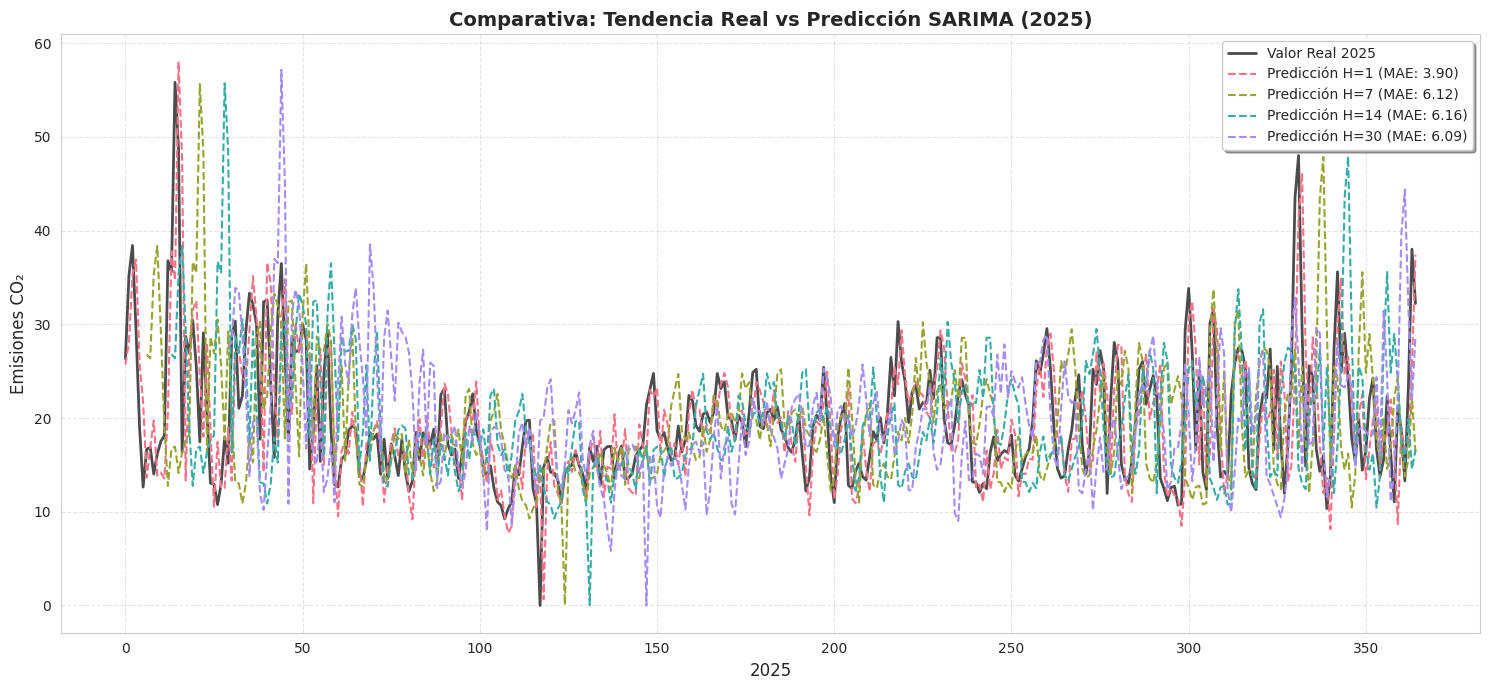

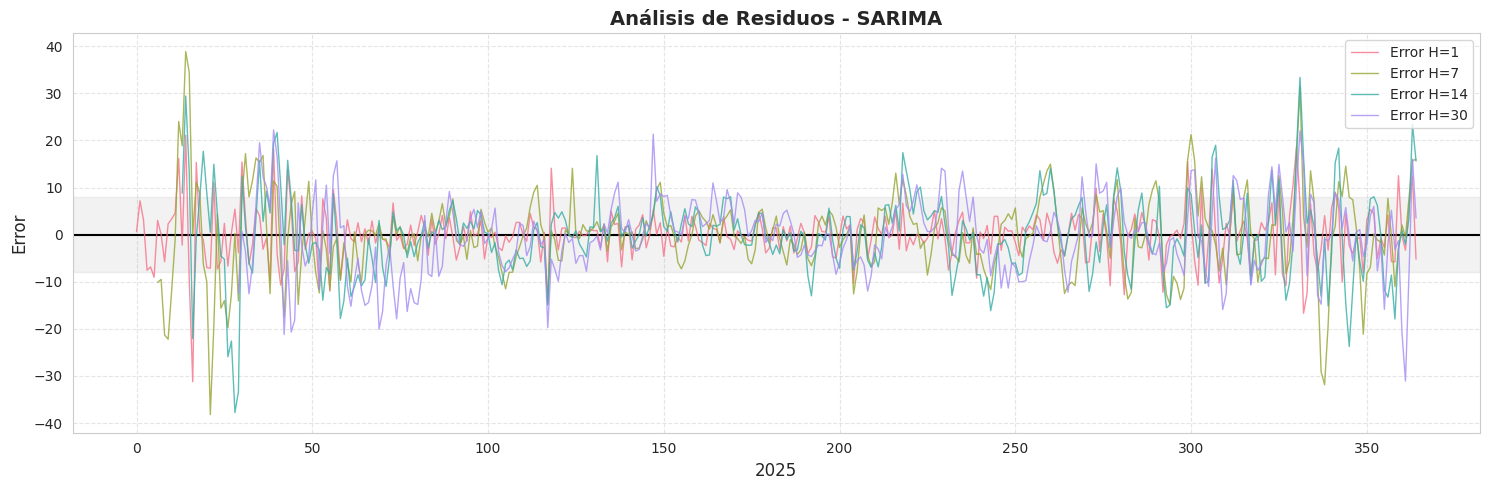

In [ ]:
# =============================================================================
# SARIMA - Gráficos
# =============================================================================

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
colores = sns.color_palette("husl", len(resultados_sarima))

if len(resultados_sarima) > 0:
    y_real_base = resultados_sarima[0]['y_true']

    # --- Gráfico 1: Horizontes de predicción ---
    plt.figure(figsize=(15, 7))

    # Forzar conversión a array 1D
    y_real_plot = np.array(y_real_base).flatten()
    plt.plot(y_real_plot, label='Valor Real 2025', color='black', linewidth=2, alpha=0.7)

    for i, res in enumerate(resultados_sarima):
        h = res['h']
        preds_plot = np.array(res['preds']).flatten()

        diferencia_len = len(y_real_plot) - len(preds_plot)

        if diferencia_len == 0:
            plt.plot(preds_plot, label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)
        else:
            plt.plot(range(diferencia_len, len(y_real_plot)), preds_plot,
                     label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)

    plt.title('Comparativa: Tendencia Real vs Predicción SARIMA (2025)', fontsize=14, fontweight='bold')
    plt.ylabel('Emisiones CO₂', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Gráfico 2: Residuos ---
    plt.figure(figsize=(15, 5))
    plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

    for i, res in enumerate(resultados_sarima):
        h = res['h']
        preds_plot = np.array(res['preds']).flatten()
        y_te_plot = np.array(res['y_true']).flatten()

        diferencia_len = len(y_real_plot) - len(preds_plot)
        residuo = y_te_plot - preds_plot

        if diferencia_len == 0:
            plt.plot(residuo, label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)
        else:
            plt.plot(range(diferencia_len, len(y_real_plot)), residuo,
                     label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)

    plt.title('Análisis de Residuos - SARIMA', fontsize=14, fontweight='bold')
    plt.ylabel('Error', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True)

    # Banda de ±1 std
    std_error = residuo.std()
    plt.axhspan(-std_error, std_error, color='gray', alpha=0.1)

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# Resumen

print(f"\n{'='*70}")
print("RESUMEN FINAL - SARIMA")
print(f"{'='*70}")
print(f"{'Horizonte':<12} {'MAE':<10} {'R²':<10} {'Mejora':<12} {'Var ratio':<10}")
print(f"{'-'*70}")

for r in resultados_sarima:
    print(f"H={r['h']:2d} días    {r['mae']:7.4f}    {r['r2']:7.4f}    {r['mejora']:+6.1f}%      {r['var_ratio']:7.2f}")

print(f"{'='*70}")


RESUMEN FINAL - SARIMA
Horizonte    MAE        R²         Mejora       Var ratio 
----------------------------------------------------------------------
H= 1 días     3.8963     0.3072      +2.2%         1.02
H= 7 días     6.1200    -0.7438      +0.1%         1.01
H=14 días     6.1572    -0.6893      +0.0%         1.03
H=30 días     6.0881    -0.7759      +4.4%         1.24


###Estacion 35


In [ ]:

df_total_35 = df_total_35.sort_index()

y_train = df_total_35['2010':'2023']
y_val = df_total_35['2024':'2024']
y_test = df_total_35['2025':]

# Check
print(f"y_train: {len(y_train)} días ({y_train.index.min()} a {y_train.index.max()})")
print(f"y_val: {len(y_val)} días ({y_val.index.min()} a {y_val.index.max()})")
print(f"y_test: {len(y_test)} días ({y_test.index.min()} a {y_test.index.max()})")

y_train: 5052 días (2010-01-01 00:00:00 a 2023-12-31 00:00:00)
y_val: 366 días (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
y_test: 365 días (2025-01-01 00:00:00 a 2025-12-31 00:00:00)


In [ ]:
p=0
d =1
q= 7

seasonal_order=(1, 1, 0, 7)

In [ ]:
# Modelo

horizontes = [1, 7, 14, 30]
resultados_sarima = []

train_val = pd.concat([y_train, y_val])

print("Entrenando modelo SARIMA base...")
model_base = SARIMAX(
    train_val,
    order=(p, d, q),
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_base = model_base.fit(disp=False)
params = res_base.params
print("Modelo base entrenado.\n")

for h in horizontes:
    print(f"\n{'='*70}")
    print(f"HORIZONTE H={h} DÍAS")
    print(f"{'='*70}")

    preds_list = []
    y_true_list = []

    print("  Iniciando rolling forecast...")

    for i in range(len(y_test) - h + 1):

        history = pd.concat([train_val, y_test.iloc[:i]]) if i > 0 else train_val

        model = SARIMAX(
            history,
            order=(p, d, q),
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.filter(params)

        forecast = res.get_forecast(steps=h)
        pred_h = forecast.predicted_mean.iloc[-1]

        preds_list.append(pred_h)
        y_true_list.append(y_test.values[i + h - 1])

        if (i + 1) % 50 == 0:
            print(f"  Procesado {i+1}/{len(y_test) - h + 1}")

    preds = np.array(preds_list)
    y_te = np.array(y_true_list)

    # Métricas
    mae = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    r2 = r2_score(y_te, preds)

    naive_mae = mean_absolute_error(y_test.values[h:], y_test.values[:-h])
    mejora = (naive_mae - mae) / naive_mae * 100

    var_preds = np.var(preds)
    var_real = np.var(y_te)
    var_ratio = var_preds / var_real if var_real > 0 else 0

    resultados_sarima.append({
        'h': h,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'naive_mae': naive_mae,
        'mejora': mejora,
        'var_ratio': var_ratio,
        'preds': preds,
        'y_true': y_te
    })

    print(f"\n RESULTADOS H={h}:")
    print(f"   MAE:              {mae:.4f}")
    print(f"   RMSE:             {rmse:.4f}")
    print(f"   R²:               {r2:.4f}")
    print(f"   Naive baseline:   {naive_mae:.4f}")
    print(f"   Mejora:           {mejora:+.1f}%")
    print(f"   Var ratio:        {var_ratio:.2f}")

Entrenando modelo SARIMA base...
Modelo base entrenado.


HORIZONTE H=1 DÍAS
  Iniciando rolling forecast...
  Procesado 50/365
  Procesado 100/365
  Procesado 150/365
  Procesado 200/365
  Procesado 250/365
  Procesado 300/365
  Procesado 350/365

📊 RESULTADOS H=1:
   MAE:              3.3321
   RMSE:             5.0782
   R²:               0.0763
   Naive baseline:   3.3786
   Mejora:           +1.4%
   Var ratio:        0.98

HORIZONTE H=7 DÍAS
  Iniciando rolling forecast...
  Procesado 50/359
  Procesado 100/359
  Procesado 150/359
  Procesado 200/359
  Procesado 250/359
  Procesado 300/359
  Procesado 350/359

📊 RESULTADOS H=7:
   MAE:              4.8953
   RMSE:             7.0270
   R²:               -0.7835
   Naive baseline:   4.8976
   Mejora:           +0.0%
   Var ratio:        0.99

HORIZONTE H=14 DÍAS
  Iniciando rolling forecast...
  Procesado 50/352
  Procesado 100/352
  Procesado 150/352
  Procesado 200/352
  Procesado 250/352
  Procesado 300/352
  Procesado 350/352


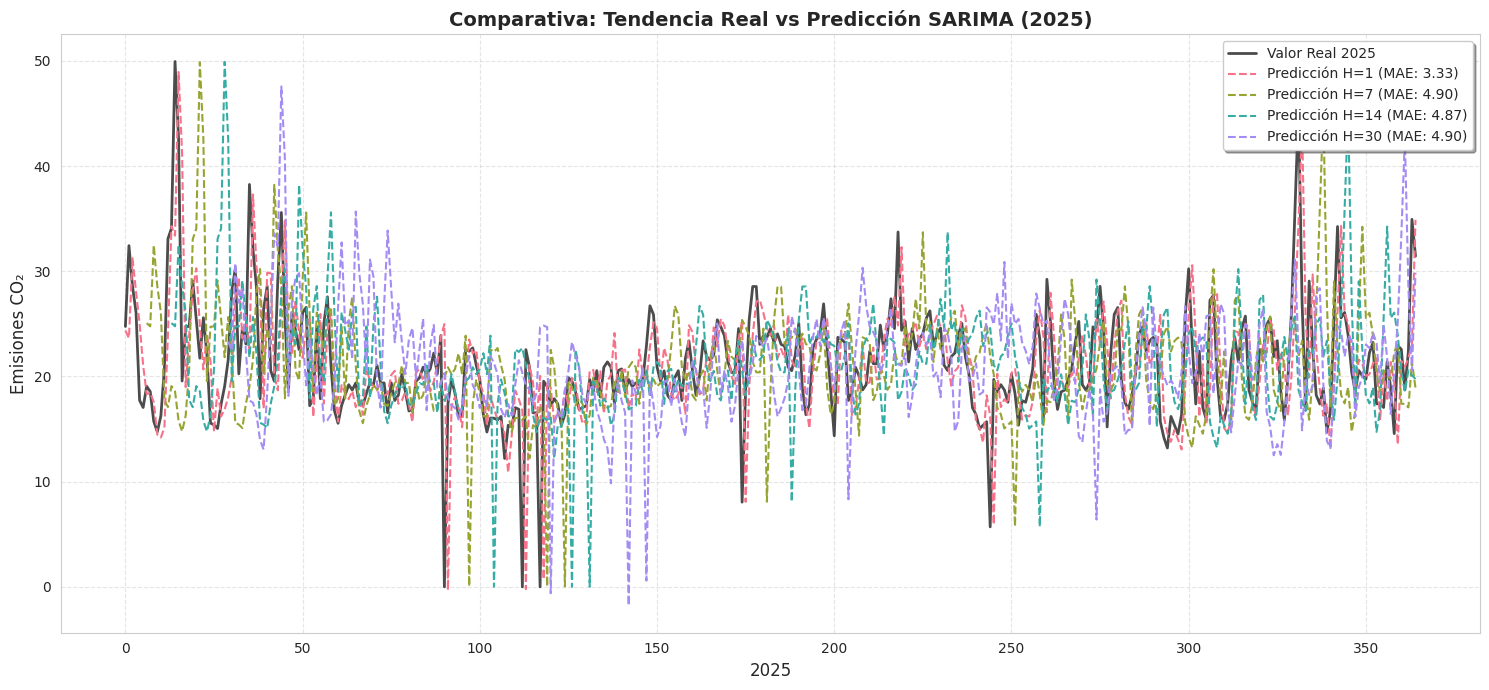

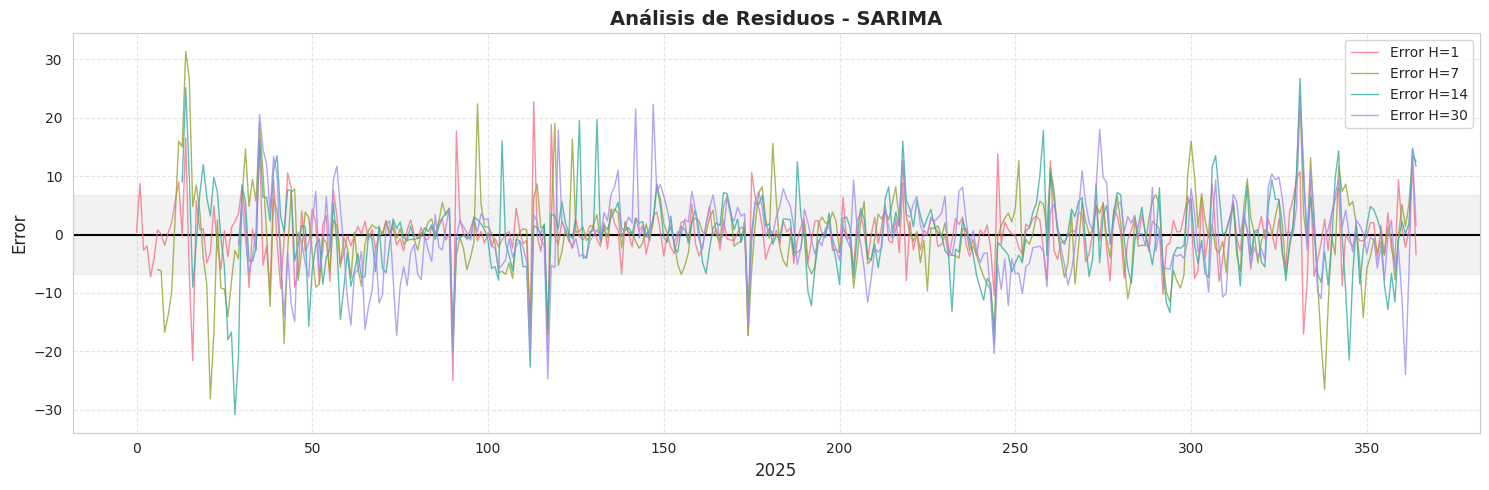

In [ ]:
# Grafico

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
colores = sns.color_palette("husl", len(resultados_sarima))

if len(resultados_sarima) > 0:
    y_real_base = resultados_sarima[0]['y_true']

    plt.figure(figsize=(15, 7))
    y_real_plot = np.array(y_real_base).flatten()
    plt.plot(y_real_plot, label='Valor Real 2025', color='black', linewidth=2, alpha=0.7)

    for i, res in enumerate(resultados_sarima):
        h = res['h']
        preds_plot = np.array(res['preds']).flatten()

        diferencia_len = len(y_real_plot) - len(preds_plot)

        if diferencia_len == 0:
            plt.plot(preds_plot, label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)
        else:
            plt.plot(range(diferencia_len, len(y_real_plot)), preds_plot,
                     label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)

    plt.title('Comparativa: Tendencia Real vs Predicción SARIMA (2025)', fontsize=14, fontweight='bold')
    plt.ylabel('Emisiones CO₂', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Residuos
    plt.figure(figsize=(15, 5))
    plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

    for i, res in enumerate(resultados_sarima):
        h = res['h']
        preds_plot = np.array(res['preds']).flatten()
        y_te_plot = np.array(res['y_true']).flatten()

        diferencia_len = len(y_real_plot) - len(preds_plot)
        residuo = y_te_plot - preds_plot

        if diferencia_len == 0:
            plt.plot(residuo, label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)
        else:
            plt.plot(range(diferencia_len, len(y_real_plot)), residuo,
                     label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)

    plt.title('Análisis de Residuos - SARIMA', fontsize=14, fontweight='bold')
    plt.ylabel('Error', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True)

    std_error = residuo.std()
    plt.axhspan(-std_error, std_error, color='gray', alpha=0.1)

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# Resumen

print(f"\n{'='*70}")
print("RESUMEN FINAL - SARIMA")
print(f"{'='*70}")
print(f"{'Horizonte':<12} {'MAE':<10} {'R²':<10} {'Mejora':<12} {'Var ratio':<10}")
print(f"{'-'*70}")

for r in resultados_sarima:
    print(f"H={r['h']:2d} días    {r['mae']:7.4f}    {r['r2']:7.4f}    {r['mejora']:+6.1f}%      {r['var_ratio']:7.2f}")

print(f"{'='*70}")


RESUMEN FINAL - SARIMA
Horizonte    MAE        R²         Mejora       Var ratio 
----------------------------------------------------------------------
H= 1 días     3.3321     0.0763      +1.4%         0.98
H= 7 días     4.8953    -0.7835      +0.0%         0.99
H=14 días     4.8656    -0.7202      -0.2%         1.01
H=30 días     4.8958    -0.9264      +3.3%         1.20


###Estacion 57


In [ ]:

df_total_57 = df_total_57.sort_index()


y_train = df_total_57['2010':'2023']
y_val = df_total_57['2024':'2024']
y_test = df_total_57['2025':]


print(f"y_train: {len(y_train)} días ({y_train.index.min()} a {y_train.index.max()})")
print(f"y_val: {len(y_val)} días ({y_val.index.min()} a {y_val.index.max()})")
print(f"y_test: {len(y_test)} días ({y_test.index.min()} a {y_test.index.max()})")

y_train: 5113 días (2010-01-01 00:00:00 a 2023-12-31 00:00:00)
y_val: 366 días (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
y_test: 365 días (2025-01-01 00:00:00 a 2025-12-31 00:00:00)


In [ ]:
p=0
d =1
q= 7

seasonal_order=(1, 1, 0, 7)

In [ ]:
# Modelo

horizontes = [1, 7, 14, 30]
resultados_sarima = []

train_val = pd.concat([y_train, y_val])

print("Entrenando modelo SARIMA base...")
model_base = SARIMAX(
    train_val,
    order=(p, d, q),
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_base = model_base.fit(disp=False)
params = res_base.params
print("Modelo base entrenado.\n")

for h in horizontes:
    print(f"\n{'='*70}")
    print(f"HORIZONTE H={h} DÍAS")
    print(f"{'='*70}")

    preds_list = []
    y_true_list = []

    print("  Iniciando rolling forecast...")

    for i in range(len(y_test) - h + 1):

        history = pd.concat([train_val, y_test.iloc[:i]]) if i > 0 else train_val

        model = SARIMAX(
            history,
            order=(p, d, q),
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.filter(params)

        forecast = res.get_forecast(steps=h)
        pred_h = forecast.predicted_mean.iloc[-1]

        preds_list.append(pred_h)
        y_true_list.append(y_test.values[i + h - 1])

        if (i + 1) % 50 == 0:
            print(f"  Procesado {i+1}/{len(y_test) - h + 1}")

    preds = np.array(preds_list)
    y_te = np.array(y_true_list)

    # Métricas
    mae = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    r2 = r2_score(y_te, preds)

    naive_mae = mean_absolute_error(y_test.values[h:], y_test.values[:-h])
    mejora = (naive_mae - mae) / naive_mae * 100

    var_preds = np.var(preds)
    var_real = np.var(y_te)
    var_ratio = var_preds / var_real if var_real > 0 else 0

    resultados_sarima.append({
        'h': h,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'naive_mae': naive_mae,
        'mejora': mejora,
        'var_ratio': var_ratio,
        'preds': preds,
        'y_true': y_te
    })

    print(f"\n RESULTADOS H={h}:")
    print(f"   MAE:              {mae:.4f}")
    print(f"   RMSE:             {rmse:.4f}")
    print(f"   R²:               {r2:.4f}")
    print(f"   Naive baseline:   {naive_mae:.4f}")
    print(f"   Mejora:           {mejora:+.1f}%")
    print(f"   Var ratio:        {var_ratio:.2f}")

Entrenando modelo SARIMA base...
Modelo base entrenado.


HORIZONTE H=1 DÍAS
  Iniciando rolling forecast...
  Procesado 50/365
  Procesado 100/365
  Procesado 150/365
  Procesado 200/365
  Procesado 250/365
  Procesado 300/365
  Procesado 350/365

 RESULTADOS H=1:
   MAE:              5.3471
   RMSE:             7.9666
   R²:               0.1832
   Naive baseline:   5.5566
   Mejora:           +3.8%
   Var ratio:        1.00

HORIZONTE H=7 DÍAS
  Iniciando rolling forecast...
  Procesado 50/359
  Procesado 100/359
  Procesado 150/359
  Procesado 200/359
  Procesado 250/359
  Procesado 300/359
  Procesado 350/359

 RESULTADOS H=7:
   MAE:              7.5820
   RMSE:             10.7930
   R²:               -0.5935
   Naive baseline:   7.5793
   Mejora:           -0.0%
   Var ratio:        1.05

HORIZONTE H=14 DÍAS
  Iniciando rolling forecast...
  Procesado 50/352
  Procesado 100/352
  Procesado 150/352
  Procesado 200/352
  Procesado 250/352
  Procesado 300/352
  Procesado 350/352



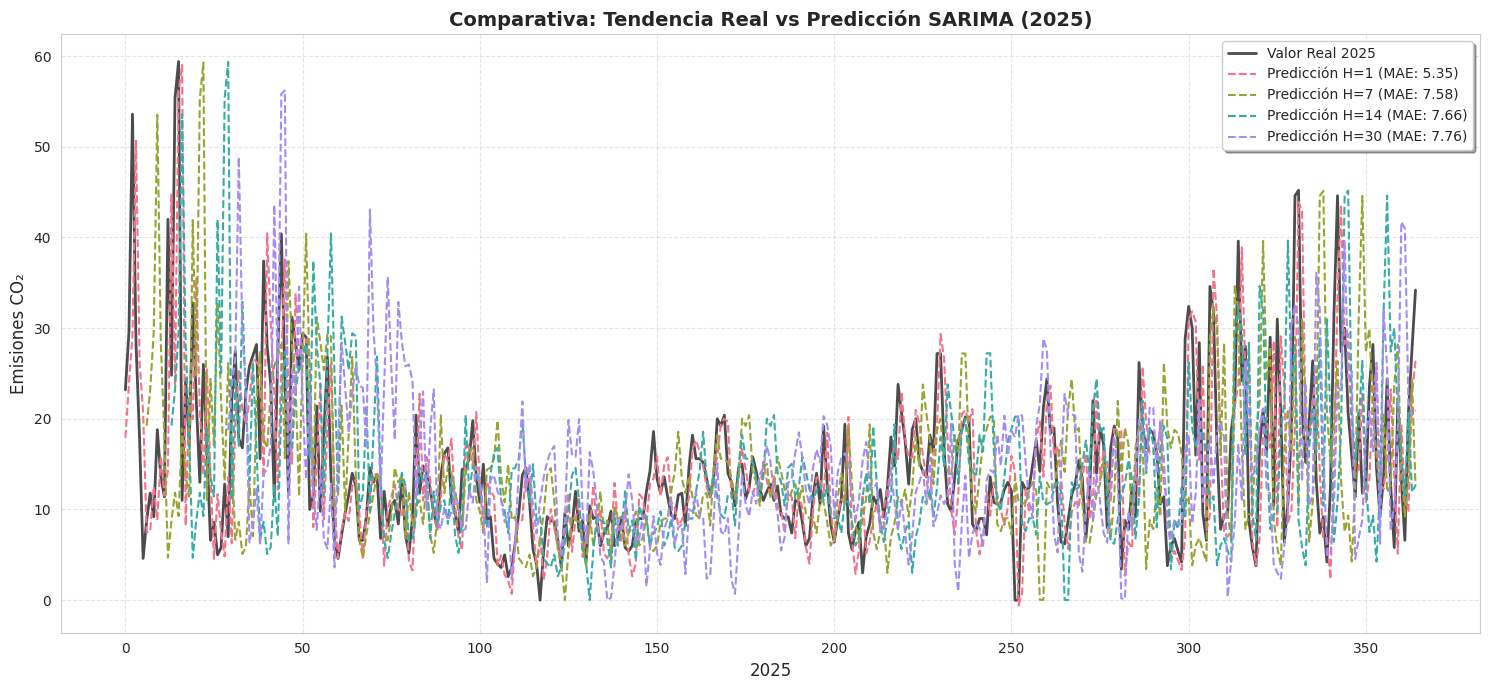

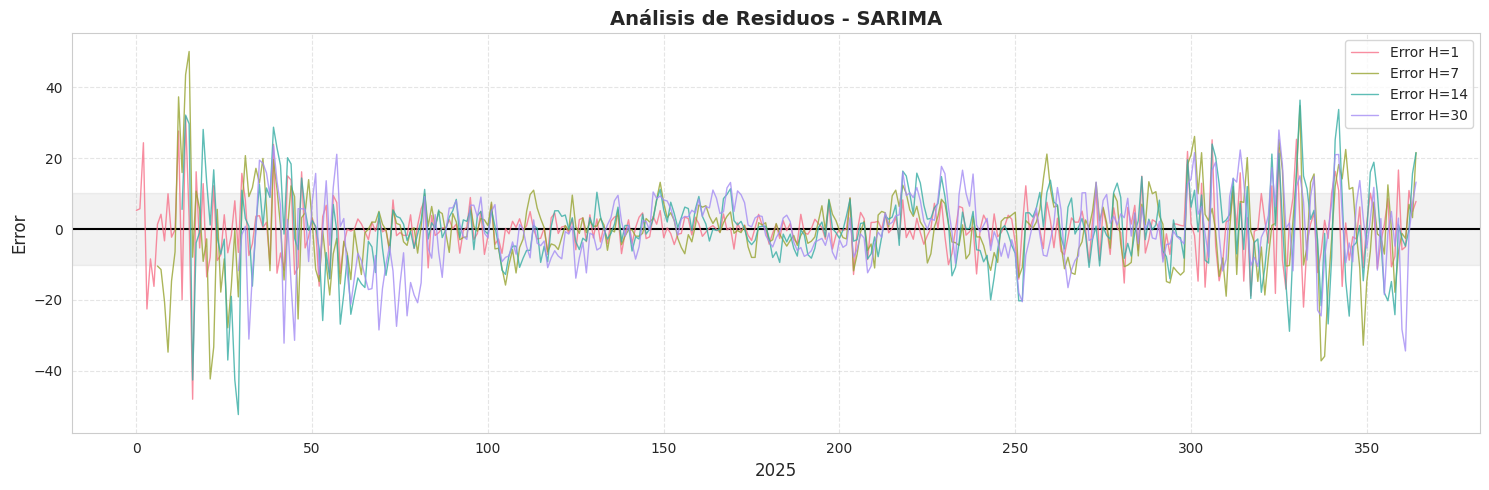

In [ ]:
# Grafico

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
colores = sns.color_palette("husl", len(resultados_sarima))

if len(resultados_sarima) > 0:
    y_real_base = resultados_sarima[0]['y_true']

    plt.figure(figsize=(15, 7))
    y_real_plot = np.array(y_real_base).flatten()
    plt.plot(y_real_plot, label='Valor Real 2025', color='black', linewidth=2, alpha=0.7)

    for i, res in enumerate(resultados_sarima):
        h = res['h']
        preds_plot = np.array(res['preds']).flatten()

        diferencia_len = len(y_real_plot) - len(preds_plot)

        if diferencia_len == 0:
            plt.plot(preds_plot, label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)
        else:
            plt.plot(range(diferencia_len, len(y_real_plot)), preds_plot,
                     label=f'Predicción H={h} (MAE: {res["mae"]:.2f})',
                     linestyle='--', color=colores[i], linewidth=1.5)

    plt.title('Comparativa: Tendencia Real vs Predicción SARIMA (2025)', fontsize=14, fontweight='bold')
    plt.ylabel('Emisiones CO₂', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Residuos
    plt.figure(figsize=(15, 5))
    plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

    for i, res in enumerate(resultados_sarima):
        h = res['h']
        preds_plot = np.array(res['preds']).flatten()
        y_te_plot = np.array(res['y_true']).flatten()

        diferencia_len = len(y_real_plot) - len(preds_plot)
        residuo = y_te_plot - preds_plot

        if diferencia_len == 0:
            plt.plot(residuo, label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)
        else:
            plt.plot(range(diferencia_len, len(y_real_plot)), residuo,
                     label=f'Error H={h}', color=colores[i], linewidth=1, alpha=0.8)

    plt.title('Análisis de Residuos - SARIMA', fontsize=14, fontweight='bold')
    plt.ylabel('Error', fontsize=12)
    plt.xlabel('2025', fontsize=12)
    plt.legend(loc='upper right', frameon=True)

    std_error = residuo.std()
    plt.axhspan(-std_error, std_error, color='gray', alpha=0.1)

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# Resumen

print(f"\n{'='*70}")
print("RESUMEN FINAL - SARIMA")
print(f"{'='*70}")
print(f"{'Horizonte':<12} {'MAE':<10} {'R²':<10} {'Mejora':<12} {'Var ratio':<10}")
print(f"{'-'*70}")

for r in resultados_sarima:
    print(f"H={r['h']:2d} días    {r['mae']:7.4f}    {r['r2']:7.4f}    {r['mejora']:+6.1f}%      {r['var_ratio']:7.2f}")

print(f"{'='*70}")


RESUMEN FINAL - SARIMA
Horizonte    MAE        R²         Mejora       Var ratio 
----------------------------------------------------------------------
H= 1 días     5.3471     0.1832      +3.8%         1.00
H= 7 días     7.5820    -0.5935      -0.0%         1.05
H=14 días     7.6640    -0.6919      +0.1%         1.07
H=30 días     7.7554    -0.6542      +2.3%         1.24
